In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import numpy as np
import random
from tqdm import tqdm
from datetime import datetime
import json
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# ==========================================
# 데이터 필터링 유틸리티
# ==========================================

def check_mask_quality(mask_path):
    """
    마스크 품질 검사
    Returns: (is_valid, num_components, touches_boundary)
    """
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            return False, 0, False
        
        # 이진화
        _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # 연결 컴포넌트 개수 확인
        labeled_mask, num_components = ndimage.label(mask_binary > 0)
        
        # 경계 터치 확인
        h, w = mask_binary.shape
        top = np.any(mask_binary[0, :] > 0)
        bottom = np.any(mask_binary[-1, :] > 0)
        left = np.any(mask_binary[:, 0] > 0)
        right = np.any(mask_binary[:, -1] > 0)
        touches_boundary = top or bottom or left or right
        
        # 유효성 판단: 컴포넌트 2개이고 경계에 닿지 않음
        # is_valid = (num_components == 2) and (not touches_boundary)
        is_valid = (num_components == 2)
        
        return is_valid, num_components, touches_boundary
        
    except Exception as e:
        return False, 0, False


def filter_valid_samples(root_dir, classes, verbose=True):
    """
    유효한 샘플만 필터링
    
    제외 기준:
    - 컴포넌트 1개, 3개 이상
    - 경계에 닿는 마스크
    - 마스크 파일 없음
    """
    valid_samples = {}
    filtered_stats = {cls: {'total': 0, 'valid': 0, 'no_mask': 0, 'multi_component': 0, 'boundary': 0} 
                     for cls in classes}
    
    if verbose:
        print("\n" + "="*60)
        print("데이터 품질 필터링 중...")
        print("="*60)
    
    for class_name in classes:
        image_folder = os.path.join(root_dir, class_name, 'images')
        mask_folder = os.path.join(root_dir, class_name, 'masks')
        
        if not os.path.exists(image_folder):
            if verbose:
                print(f"⚠ 이미지 폴더 없음: {image_folder}")
            continue
        
        # 이미지 파일 목록
        image_files = [f.replace('.png', '') for f in os.listdir(image_folder) 
                      if f.endswith('.png')]
        
        filtered_stats[class_name]['total'] = len(image_files)
        
        valid_files = []
        
        for file_name in image_files:
            # 마스크 경로 찾기
            mask_path = None
            
            # 여러 가지 파일명 형식 시도
            for variant in [file_name, 
                           f"{file_name.split('-')[0].capitalize()}-{'-'.join(file_name.split('-')[1:])}" if '-' in file_name else file_name,
                           file_name.lower()]:
                test_path = os.path.join(mask_folder, f'{variant}.png')
                if os.path.exists(test_path):
                    mask_path = test_path
                    break
            
            # 마스크 없음
            if mask_path is None:
                filtered_stats[class_name]['no_mask'] += 1
                continue
            
            # 마스크 품질 검사
            is_valid, num_components, touches_boundary = check_mask_quality(mask_path)
            
            if is_valid:
                valid_files.append(file_name)
                filtered_stats[class_name]['valid'] += 1

                if touches_boundary:
                    filtered_stats[class_name]['boundary'] += 1
                    
            else:
                if num_components > 2:
                    filtered_stats[class_name]['multi_component'] += 1
                
        
        valid_samples[class_name] = valid_files
        
        if verbose:
            print(f"\n[{class_name}]")
            print(f"  총 이미지: {filtered_stats[class_name]['total']}개")
            print(f"  유효 샘플: {filtered_stats[class_name]['valid']}개")
            print(f"  제외 - 마스크 없음: {filtered_stats[class_name]['no_mask']}개")
            print(f"  제외 - 다중 컴포넌트: {filtered_stats[class_name]['multi_component']}개")
            print(f"  포함 - 경계 터치: {filtered_stats[class_name]['boundary']}개")
    
    if verbose:
        print("\n" + "="*60)
        total_valid = sum(len(files) for files in valid_samples.values())
        total_all = sum(stats['total'] for stats in filtered_stats.values())
        print(f"전체 유효 샘플: {total_valid:,}개 / {total_all:,}개 ({total_valid/total_all*100:.1f}%)")
        print("="*60 + "\n")
    
    return valid_samples, filtered_stats


# ==========================================
# 데이터셋 및 로더
# ==========================================

class COVID19SegmentationDataset(Dataset):
    """
    COVID-19 Radiography Segmentation Dataset (필터링 버전)
    유효한 샘플만 로드
    """
    
    def __init__(self, root_dir, valid_samples, transform=None, split='train', 
                 train_ratio=0.8, random_seed=42):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        # 클래스 정의
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 데이터 로드
        self.data = []
        
        np.random.seed(random_seed)
        
        for class_name in self.classes:
            if class_name not in valid_samples:
                continue
            
            file_names = valid_samples[class_name]
            
            if len(file_names) == 0:
                continue
            
            # 이미지 및 마스크 폴더 경로
            image_folder = os.path.join(root_dir, class_name, 'images')
            mask_folder = os.path.join(root_dir, class_name, 'masks')
            
            # 데이터 분할
            n_samples = len(file_names)
            indices = np.random.permutation(n_samples)
            
            train_size = int(n_samples * train_ratio)
            val_size = int(n_samples * (1 - train_ratio) / 2)
            
            if split == 'train':
                selected_indices = indices[:train_size]
            elif split == 'val':
                selected_indices = indices[train_size:train_size + val_size]
            else:  # test
                selected_indices = indices[train_size + val_size:]
            
            # 선택된 파일들 추가
            for idx in selected_indices:
                file_name = file_names[idx]
                
                # 이미지 경로 찾기
                image_path = None
                mask_path = None
                
                for variant in [file_name,
                               f"{file_name.split('-')[0].capitalize()}-{'-'.join(file_name.split('-')[1:])}" if '-' in file_name else file_name,
                               file_name.lower()]:
                    test_image = os.path.join(image_folder, f'{variant}.png')
                    test_mask = os.path.join(mask_folder, f'{variant}.png')
                    
                    if os.path.exists(test_image) and os.path.exists(test_mask):
                        image_path = test_image
                        mask_path = test_mask
                        break
                
                if image_path and mask_path:
                    self.data.append({
                        'image': image_path,
                        'mask': mask_path,
                        'class': class_name,
                        'class_idx': self.class_to_idx[class_name]
                    })
        
        print(f"{split.upper()} 데이터셋 로드 완료: {len(self.data)}개 샘플")
        self._print_class_distribution()
    
    def _print_class_distribution(self):
        """클래스별 데이터 분포 출력"""
        class_counts = {cls: 0 for cls in self.classes}
        for item in self.data:
            class_counts[item['class']] += 1
        
        print(f"클래스별 분포:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}개")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 이미지 로드 (RGB)
        image = Image.open(item['image']).convert('RGB')
        
        # 마스크 로드 (Grayscale)
        mask = Image.open(item['mask']).convert('L')
        
        # Transform 적용
        if self.transform:
            image, mask = self.transform(image, mask)
        
        class_idx = item['class_idx']
        
        return image, mask, class_idx


class SegmentationTransform:
    """
    이미지와 마스크에 동일한 변환을 적용하는 Transform 클래스
    """
    
    def __init__(self, image_size=256, augment=True):
        self.image_size = image_size
        self.augment = augment
        
        # 이미지 정규화
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, [self.image_size, self.image_size])
        mask = TF.resize(mask, [self.image_size, self.image_size], 
                        interpolation=transforms.InterpolationMode.NEAREST)
        
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            # Random vertical flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            # Random rotation
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            
            # Color jitter (이미지만)
            if random.random() > 0.5:
                image = transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2
                )(image)
        
        # ToTensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # 마스크 이진화
        mask = (mask > 0.5).float()
        
        # 이미지 정규화
        image = self.normalize(image)
        
        # 마스크는 [1, H, W] -> [H, W]로 변환
        mask = mask.squeeze(0)
        
        return image, mask


def create_segmentation_dataloaders(root_dir, batch_size=16, image_size=256,
                                   train_ratio=0.8, num_workers=4, random_seed=42):
    """
    Segmentation DataLoader 생성 함수 (필터링 적용)
    """
    # 클래스 정의
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    # 유효한 샘플 필터링
    valid_samples, filtered_stats = filter_valid_samples(root_dir, classes, verbose=True)
    
    # Transform 생성
    train_transform = SegmentationTransform(image_size=image_size, augment=True)
    val_transform = SegmentationTransform(image_size=image_size, augment=False)
    
    # Dataset 생성
    train_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        valid_samples=valid_samples,
        transform=train_transform,
        split='train',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    val_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        valid_samples=valid_samples,
        transform=val_transform,
        split='val',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    test_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        valid_samples=valid_samples,
        transform=val_transform,
        split='test',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    # DataLoader 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, filtered_stats


# ==========================================
# 모델 정의 (동일)
# ==========================================

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """Standard U-Net architecture"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


def get_model(model_name='unet', n_channels=3, n_classes=1, pretrained=True):
    """모델 생성 함수"""
    if model_name == 'unet':
        model = UNet(n_channels=n_channels, n_classes=n_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model


# ==========================================
# Loss 함수
# ==========================================

class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice


class DiceBCELoss(nn.Module):
    """Combination of Dice Loss and BCE Loss"""
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super(DiceBCELoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        dice_loss = self.dice(pred, target)
        bce_loss = self.bce(pred, target)
        
        return self.weight_dice * dice_loss + self.weight_bce * bce_loss


def get_loss_function(loss_name='dice_bce'):
    """Loss 함수 생성"""
    if loss_name == 'dice':
        return DiceLoss()
    elif loss_name == 'bce':
        return nn.BCEWithLogitsLoss()
    elif loss_name == 'dice_bce':
        return DiceBCELoss()
    else:
        raise ValueError(f"Unknown loss: {loss_name}")


# ==========================================
# Early Stopping
# ==========================================

class EarlyStopping:
    """Early Stopping 클래스"""
    
    def __init__(self, patience=7, delta=0, verbose=True):
        """
        Args:
            patience: validation loss가 개선되지 않아도 기다릴 epoch 수
            delta: 개선으로 간주할 최소 변화량
            verbose: 메시지 출력 여부
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
    
    def __call__(self, val_loss):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'  EarlyStopping counter: {self.counter}/{self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


# ==========================================
# 시각화 함수
# ==========================================

def visualize_val_predictions(model, val_loader, device, epoch, save_dir, num_samples=2):
    """
    Validation 예측 결과 시각화 (2개 샘플, 원본+예측만)
    """
    model.eval()
    
    images_list = []
    masks_list = []
    preds_list = []
    class_indices_list = []
    
    with torch.no_grad():
        for images, masks, class_indices in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            images_list.append(images.cpu())
            preds_list.append(preds.squeeze(1).cpu())
            class_indices_list.append(class_indices.cpu())
            
            if len(images_list) * images.size(0) >= num_samples:
                break
    
    images_all = torch.cat(images_list, dim=0)[:num_samples]
    preds_all = torch.cat(preds_list, dim=0)[:num_samples]
    class_indices_all = torch.cat(class_indices_list, dim=0)[:num_samples]
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    idx_to_class = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
    
    for i in range(num_samples):
        # Denormalize image
        img = images_all[i] * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        pred = preds_all[i].numpy()
        class_name = idx_to_class[class_indices_all[i].item()]
        
        # Original Image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original - {class_name}', fontsize=12)
        axes[i, 0].axis('off')
        
        # Prediction Overlay
        axes[i, 1].imshow(img)
        axes[i, 1].imshow(pred, cmap='Reds', alpha=0.5)
        axes[i, 1].set_title(f'Prediction - {class_name}', fontsize=12)
        axes[i, 1].axis('off')
    
    plt.suptitle(f'Validation Predictions - Epoch {epoch}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, f'val_pred_epoch_{epoch:03d}.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


# ==========================================
# Trainer 클래스 (Early Stopping 추가)
# ==========================================

class SegmentationTrainer:
    """Segmentation 모델 학습 클래스"""
    
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        save_dir='seg_results',
        use_amp=True,
        multi_gpu=True,
        visualize_freq=5,
        early_stopping_patience=10
    ):
        self.device = device
        self.save_dir = save_dir
        self.use_amp = use_amp
        self.visualize_freq = visualize_freq
        
        # 저장 디렉토리 생성
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(os.path.join(save_dir, 'val_predictions'), exist_ok=True)
        
        # Multi-GPU 설정
        if multi_gpu and torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            model = model.to(f'cuda:0')
            self.model = nn.DataParallel(model, device_ids=[0, 1])
        else:
            self.model = model.to(device)
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        
        # Mixed Precision Training
        self.scaler = GradScaler() if use_amp else None
        
        # Early Stopping
        self.early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)
        
        # 학습 기록
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': [],
            'lr': []
        }
        
        self.best_val_dice = 0.0
        self.best_epoch = 0
    
    def calculate_metrics(self, pred, target, threshold=0.5):
        """Dice Score와 IoU 계산"""
        pred = torch.sigmoid(pred)
        pred = (pred > threshold).float()
        target = target.float()
        
        # Dice Score
        intersection = (pred * target).sum()
        dice = (2. * intersection + 1e-7) / (pred.sum() + target.sum() + 1e-7)
        
        # IoU
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + 1e-7) / (union + 1e-7)
        
        return dice.item(), iou.item()
    
    def train_epoch(self, epoch):
        """1 Epoch 학습"""
        self.model.train()
        
        torch.cuda.empty_cache()
        
        running_loss = 0.0
        running_dice = 0.0
        running_iou = 0.0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch:03d} [TRAIN]', ncols=120)
        
        for batch_idx, (images, masks, class_indices) in enumerate(pbar):
            images = images.to(self.device)
            masks = masks.to(self.device).unsqueeze(1)
            
            # Forward pass with mixed precision
            if self.use_amp:
                with autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)
                
                self.optimizer.zero_grad()
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            # Metrics 계산
            dice, iou = self.calculate_metrics(outputs.detach(), masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            
            # Progress bar 업데이트
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'lr': f'{self.optimizer.param_groups[0]["lr"]:.6f}'
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_dice = running_dice / len(self.train_loader)
        epoch_iou = running_iou / len(self.train_loader)
        
        return epoch_loss, epoch_dice, epoch_iou
    
    def validate_epoch(self, epoch):
        """1 Epoch 검증"""
        self.model.eval()
        
        running_loss = 0.0
        running_dice = 0.0
        running_iou = 0.0
        
        pbar = tqdm(self.val_loader, desc=f'Epoch {epoch:03d} [VAL]  ', ncols=120)
        
        with torch.no_grad():
            for batch_idx, (images, masks, class_indices) in enumerate(pbar):
                images = images.to(self.device)
                masks = masks.to(self.device).unsqueeze(1)
                
                if self.use_amp:
                    with autocast():
                        outputs = self.model(images)
                        loss = self.criterion(outputs, masks)
                else:
                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)
                
                # Metrics 계산
                dice, iou = self.calculate_metrics(outputs, masks)
                
                running_loss += loss.item()
                running_dice += dice
                running_iou += iou
                
                # Progress bar 업데이트
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'dice': f'{dice:.4f}',
                    'iou': f'{iou:.4f}'
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_dice = running_dice / len(self.val_loader)
        epoch_iou = running_iou / len(self.val_loader)
        
        return epoch_loss, epoch_dice, epoch_iou
    
    def save_checkpoint(self, epoch, is_best=False):
        """체크포인트 저장"""
        if isinstance(self.model, nn.DataParallel):
            model_state = self.model.module.state_dict()
        else:
            model_state = self.model.state_dict()
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_dice': self.best_val_dice,
            'history': self.history
        }
        
        # 최신 체크포인트 저장
        checkpoint_path = os.path.join(self.save_dir, 'last_checkpoint.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Best 모델 저장
        if is_best:
            best_path = os.path.join(self.save_dir, 'best_model.pth')
            torch.save(checkpoint, best_path)
            print(f"  ✨ Best model saved! (Dice: {self.best_val_dice:.4f})")
    
    def plot_history(self):
        """학습 히스토리 시각화"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Loss
        axes[0].plot(self.history['train_loss'], label='Train Loss', marker='o', linewidth=2)
        axes[0].plot(self.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Loss History', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # Dice Score
        axes[1].plot(self.history['train_dice'], label='Train Dice', marker='o', linewidth=2)
        axes[1].plot(self.history['val_dice'], label='Val Dice', marker='s', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Dice Score', fontsize=12)
        axes[1].set_title('Dice Score History', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        
        # IoU
        axes[2].plot(self.history['train_iou'], label='Train IoU', marker='o', linewidth=2)
        axes[2].plot(self.history['val_iou'], label='Val IoU', marker='s', linewidth=2)
        axes[2].set_xlabel('Epoch', fontsize=12)
        axes[2].set_ylabel('IoU', fontsize=12)
        axes[2].set_title('IoU History', fontsize=14, fontweight='bold')
        axes[2].legend(fontsize=10)
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'), dpi=150, bbox_inches='tight')
        plt.close()
    
    def train(self, num_epochs, scheduler=None):
        """전체 학습 루프"""
        print(f"\n{'='*80}")
        print(f"{'Starting Training':^80}")
        print(f"{'='*80}")
        print(f"Device: {self.device}")
        print(f"Num GPUs: {torch.cuda.device_count()}")
        print(f"Train batches: {len(self.train_loader)}")
        print(f"Val batches: {len(self.val_loader)}")
        print(f"Mixed Precision: {self.use_amp}")
        print(f"Early Stopping Patience: {self.early_stopping.patience}")
        print(f"Visualization Frequency: Every {self.visualize_freq} epochs")
        print(f"{'='*80}\n")
        
        for epoch in range(1, num_epochs + 1):
            # 학습
            train_loss, train_dice, train_iou = self.train_epoch(epoch)
            
            # 검증
            val_loss, val_dice, val_iou = self.validate_epoch(epoch)
            
            # Learning rate scheduling
            if scheduler is not None:
                scheduler.step(val_loss)
                current_lr = self.optimizer.param_groups[0]['lr']
            else:
                current_lr = self.optimizer.param_groups[0]['lr']
            
            # 히스토리 저장
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['train_iou'].append(train_iou)
            self.history['val_iou'].append(val_iou)
            self.history['lr'].append(current_lr)
            
            # Epoch 결과 출력
            print(f"\n{'='*80}")
            print(f"{'Epoch ' + str(epoch) + '/' + str(num_epochs) + ' Summary':^80}")
            print(f"{'='*80}")
            print(f"{'Train':<10} - Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
            print(f"{'Val':<10} - Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")
            
            # Best 모델 체크
            is_best = val_dice > self.best_val_dice
            if is_best:
                self.best_val_dice = val_dice
                self.best_epoch = epoch
            
            print(f"Best Val Dice: {self.best_val_dice:.4f} (Epoch {self.best_epoch})")
            
            # 체크포인트 저장
            self.save_checkpoint(epoch, is_best)
            
            # Early Stopping 체크
            self.early_stopping(val_loss)
            
            if self.early_stopping.early_stop:
                print(f"\n{'='*80}")
                print(f"{'Early Stopping Triggered!':^80}")
                print(f"{'='*80}")
                print(f"No improvement for {self.early_stopping.patience} epochs.")
                print(f"Best Val Dice: {self.best_val_dice:.4f} (Epoch {self.best_epoch})")
                print(f"{'='*80}\n")
                break
            
            # Validation 예측 결과 시각화
            if epoch % self.visualize_freq == 0 or epoch == num_epochs or is_best:
                print(f"  📊 Generating validation predictions...")
                visualize_val_predictions(
                    model=self.model,
                    val_loader=self.val_loader,
                    device=self.device,
                    epoch=epoch,
                    save_dir=os.path.join(self.save_dir, 'val_predictions'),
                    num_samples=2
                )
            
            # 히스토리 플롯
            if epoch % self.visualize_freq == 0 or epoch == num_epochs:
                self.plot_history()
            
            print(f"{'='*80}\n")
        
        print(f"\n{'='*80}")
        print(f"{'Training Completed!':^80}")
        print(f"{'='*80}")
        print(f"Best Val Dice: {self.best_val_dice:.4f} (Epoch {self.best_epoch})")
        print(f"Model saved in: {self.save_dir}")
        print(f"{'='*80}\n")
        
        return self.history


# ==========================================
# 메인 학습 파이프라인
# ==========================================

def main():
    # GPU 메모리 클리어
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    
    # 하이퍼파라미터 설정
    CONFIG = {
        'data_root': 'COVID-19_Radiography_Dataset',
        'model_name': 'unet',
        'loss_name': 'dice_bce',
        'batch_size': 64,
        'image_size': 224,
        'num_epochs': 150,
        'learning_rate': 4e-4,
        'weight_decay': 1e-5,
        'num_workers': 4,
        'save_dir': 'seg_results_filtered',
        'use_amp': True,
        'multi_gpu': False,
        'pretrained': True,
        'visualize_freq': 5,
        'early_stopping_patience': 10,
    }
    
    # 설정 출력
    print("\n" + "="*80)
    print(f"{'Configuration':^80}")
    print("="*80)
    for key, value in CONFIG.items():
        print(f"{key:.<30} {str(value):>49}")
    print("="*80 + "\n")
    
    # Device 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU Count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    print()
    
    # 데이터 로더 생성 (필터링 적용)
    print("Loading datasets...")
    train_loader, val_loader, test_loader, filtered_stats = create_segmentation_dataloaders(
        root_dir=CONFIG['data_root'],
        batch_size=CONFIG['batch_size'],
        image_size=CONFIG['image_size'],
        train_ratio=0.8,
        num_workers=CONFIG['num_workers']
    )
    print("Datasets loaded!\n")
    
    # 모델 생성
    print(f"Creating model: {CONFIG['model_name']}...")
    model = get_model(
        model_name=CONFIG['model_name'],
        n_channels=3,
        n_classes=1,
        pretrained=CONFIG['pretrained']
    )
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}\n")
    
    # Loss, Optimizer, Scheduler
    criterion = get_loss_function(CONFIG['loss_name'])
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )
    
    # Trainer 생성 및 학습
    trainer = SegmentationTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        save_dir=CONFIG['save_dir'],
        use_amp=CONFIG['use_amp'],
        multi_gpu=CONFIG['multi_gpu'],
        visualize_freq=CONFIG['visualize_freq'],
        early_stopping_patience=CONFIG['early_stopping_patience']
    )
    
    # 학습 시작
    history = trainer.train(
        num_epochs=CONFIG['num_epochs'],
        scheduler=scheduler
    )
    
    # 최종 평가
    print("Loading best model for evaluation...")
    best_checkpoint = torch.load(os.path.join(CONFIG['save_dir'], 'best_model.pth'))
    if isinstance(trainer.model, nn.DataParallel):
        trainer.model.module.load_state_dict(best_checkpoint['model_state_dict'])
    else:
        trainer.model.load_state_dict(best_checkpoint['model_state_dict'])
    
    # Test set 평가
    print("\nEvaluating on test set...")
    trainer.model.eval()
    test_loss = 0.0
    test_dice = 0.0
    test_iou = 0.0
    
    with torch.no_grad():
        for images, masks, class_indices in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)
            
            outputs = trainer.model(images)
            loss = criterion(outputs, masks)
            
            dice, iou = trainer.calculate_metrics(outputs, masks)
            
            test_loss += loss.item()
            test_dice += dice
            test_iou += iou
    
    test_loss /= len(test_loader)
    test_dice /= len(test_loader)
    test_iou /= len(test_loader)
    
    print(f"\n{'='*80}")
    print(f"{'Test Results':^80}")
    print(f"{'='*80}")
    print(f"Loss: {test_loss:.4f}")
    print(f"Dice: {test_dice:.4f}")
    print(f"IoU:  {test_iou:.4f}")
    print(f"{'='*80}\n")
    
    # 결과 저장
    results = {
        'config': CONFIG,
        'filtered_stats': filtered_stats,
        'best_epoch': trainer.best_epoch,
        'best_val_dice': trainer.best_val_dice,
        'test_loss': test_loss,
        'test_dice': test_dice,
        'test_iou': test_iou
    }
    
    with open(os.path.join(CONFIG['save_dir'], 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\n{'='*80}")
    print(f"{'All Done!':^80}")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()


                                 Configuration                                  
data_root.....................                      COVID-19_Radiography_Dataset
model_name....................                                              unet
loss_name.....................                                          dice_bce
batch_size....................                                                64
image_size....................                                               224
num_epochs....................                                               150
learning_rate.................                                            0.0004
weight_decay..................                                             1e-05
num_workers...................                                                 4
save_dir......................                              seg_results_filtered
use_amp.......................                                              True
multi_gpu..................

Epoch 001 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.25it/s, loss=0.0891, dice=0.9438, iou=0.8937]



                              Epoch 1/150 Summary                               
Train      - Loss: 0.1516 | Dice: 0.9292 | IoU: 0.8752
Val        - Loss: 0.0664 | Dice: 0.9644 | IoU: 0.9317
Learning Rate: 0.000400
Best Val Dice: 0.9644 (Epoch 1)
  ✨ Best model saved! (Dice: 0.9644)
  📊 Generating validation predictions...



Epoch 002 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.27it/s, loss=0.0576, dice=0.9567, iou=0.9169]



                              Epoch 2/150 Summary                               
Train      - Loss: 0.0493 | Dice: 0.9700 | IoU: 0.9418
Val        - Loss: 0.0411 | Dice: 0.9718 | IoU: 0.9454
Learning Rate: 0.000400
Best Val Dice: 0.9718 (Epoch 2)
  ✨ Best model saved! (Dice: 0.9718)
  📊 Generating validation predictions...



Epoch 003 [VAL]  : 100%|██████████████████████████| 33/33 [00:07<00:00,  4.16it/s, loss=0.0532, dice=0.9563, iou=0.9163]



                              Epoch 3/150 Summary                               
Train      - Loss: 0.0357 | Dice: 0.9748 | IoU: 0.9508
Val        - Loss: 0.0327 | Dice: 0.9755 | IoU: 0.9525
Learning Rate: 0.000400
Best Val Dice: 0.9755 (Epoch 3)
  ✨ Best model saved! (Dice: 0.9755)
  📊 Generating validation predictions...



Epoch 004 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.95it/s, loss=0.0598, dice=0.9494, iou=0.9037]



                              Epoch 4/150 Summary                               
Train      - Loss: 0.0315 | Dice: 0.9763 | IoU: 0.9538
Val        - Loss: 0.0308 | Dice: 0.9759 | IoU: 0.9532
Learning Rate: 0.000400
Best Val Dice: 0.9759 (Epoch 4)
  ✨ Best model saved! (Dice: 0.9759)
  📊 Generating validation predictions...



Epoch 005 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.52it/s, loss=0.0355, dice=0.9703, iou=0.9423]



                              Epoch 5/150 Summary                               
Train      - Loss: 0.0282 | Dice: 0.9782 | IoU: 0.9573
Val        - Loss: 0.0253 | Dice: 0.9800 | IoU: 0.9609
Learning Rate: 0.000400
Best Val Dice: 0.9800 (Epoch 5)
  ✨ Best model saved! (Dice: 0.9800)
  📊 Generating validation predictions...



Epoch 006 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.99it/s, loss=0.0340, dice=0.9715, iou=0.9445]



                              Epoch 6/150 Summary                               
Train      - Loss: 0.0265 | Dice: 0.9792 | IoU: 0.9593
Val        - Loss: 0.0242 | Dice: 0.9806 | IoU: 0.9620
Learning Rate: 0.000400
Best Val Dice: 0.9806 (Epoch 6)
  ✨ Best model saved! (Dice: 0.9806)
  📊 Generating validation predictions...



Epoch 007 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.72it/s, loss=0.0329, dice=0.9725, iou=0.9465]



                              Epoch 7/150 Summary                               
Train      - Loss: 0.0261 | Dice: 0.9793 | IoU: 0.9595
Val        - Loss: 0.0228 | Dice: 0.9819 | IoU: 0.9645
Learning Rate: 0.000400
Best Val Dice: 0.9819 (Epoch 7)
  ✨ Best model saved! (Dice: 0.9819)
  📊 Generating validation predictions...



Epoch 008 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.40it/s, loss=0.0331, dice=0.9719, iou=0.9454]



                              Epoch 8/150 Summary                               
Train      - Loss: 0.0246 | Dice: 0.9803 | IoU: 0.9614
Val        - Loss: 0.0226 | Dice: 0.9818 | IoU: 0.9644
Learning Rate: 0.000400
Best Val Dice: 0.9819 (Epoch 7)



Epoch 009 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.07it/s, loss=0.0316, dice=0.9737, iou=0.9487]



                              Epoch 9/150 Summary                               
Train      - Loss: 0.0237 | Dice: 0.9809 | IoU: 0.9625
Val        - Loss: 0.0220 | Dice: 0.9821 | IoU: 0.9650
Learning Rate: 0.000400
Best Val Dice: 0.9821 (Epoch 9)
  ✨ Best model saved! (Dice: 0.9821)
  📊 Generating validation predictions...



Epoch 010 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.72it/s, loss=0.0343, dice=0.9709, iou=0.9435]



                              Epoch 10/150 Summary                              
Train      - Loss: 0.0234 | Dice: 0.9811 | IoU: 0.9630
Val        - Loss: 0.0233 | Dice: 0.9811 | IoU: 0.9630
Learning Rate: 0.000400
Best Val Dice: 0.9821 (Epoch 9)
  EarlyStopping counter: 1/10
  📊 Generating validation predictions...



Epoch 011 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.26it/s, loss=0.0351, dice=0.9700, iou=0.9418]



                              Epoch 11/150 Summary                              
Train      - Loss: 0.0239 | Dice: 0.9807 | IoU: 0.9622
Val        - Loss: 0.0215 | Dice: 0.9825 | IoU: 0.9656
Learning Rate: 0.000400
Best Val Dice: 0.9825 (Epoch 11)
  ✨ Best model saved! (Dice: 0.9825)
  📊 Generating validation predictions...



Epoch 012 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.25it/s, loss=0.0293, dice=0.9748, iou=0.9508]



                              Epoch 12/150 Summary                              
Train      - Loss: 0.0224 | Dice: 0.9818 | IoU: 0.9643
Val        - Loss: 0.0204 | Dice: 0.9832 | IoU: 0.9671
Learning Rate: 0.000400
Best Val Dice: 0.9832 (Epoch 12)
  ✨ Best model saved! (Dice: 0.9832)
  📊 Generating validation predictions...



Epoch 013 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.67it/s, loss=0.0399, dice=0.9659, iou=0.9341]



                              Epoch 13/150 Summary                              
Train      - Loss: 0.0215 | Dice: 0.9824 | IoU: 0.9655
Val        - Loss: 0.0268 | Dice: 0.9779 | IoU: 0.9568
Learning Rate: 0.000400
Best Val Dice: 0.9832 (Epoch 12)
  EarlyStopping counter: 1/10



Epoch 014 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.98it/s, loss=0.0378, dice=0.9691, iou=0.9401]



                              Epoch 14/150 Summary                              
Train      - Loss: 0.0213 | Dice: 0.9826 | IoU: 0.9658
Val        - Loss: 0.0217 | Dice: 0.9822 | IoU: 0.9652
Learning Rate: 0.000400
Best Val Dice: 0.9832 (Epoch 12)
  EarlyStopping counter: 2/10



Epoch 015 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.26it/s, loss=0.0266, dice=0.9770, iou=0.9551]



                              Epoch 15/150 Summary                              
Train      - Loss: 0.0210 | Dice: 0.9829 | IoU: 0.9663
Val        - Loss: 0.0192 | Dice: 0.9841 | IoU: 0.9688
Learning Rate: 0.000400
Best Val Dice: 0.9841 (Epoch 15)
  ✨ Best model saved! (Dice: 0.9841)
  📊 Generating validation predictions...



Epoch 016 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.00it/s, loss=0.0289, dice=0.9749, iou=0.9510]



                              Epoch 16/150 Summary                              
Train      - Loss: 0.0209 | Dice: 0.9829 | IoU: 0.9663
Val        - Loss: 0.0202 | Dice: 0.9834 | IoU: 0.9674
Learning Rate: 0.000400
Best Val Dice: 0.9841 (Epoch 15)
  EarlyStopping counter: 1/10



Epoch 017 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.28it/s, loss=0.0295, dice=0.9746, iou=0.9505]



                              Epoch 17/150 Summary                              
Train      - Loss: 0.0209 | Dice: 0.9829 | IoU: 0.9664
Val        - Loss: 0.0191 | Dice: 0.9843 | IoU: 0.9692
Learning Rate: 0.000400
Best Val Dice: 0.9843 (Epoch 17)
  ✨ Best model saved! (Dice: 0.9843)
  📊 Generating validation predictions...



Epoch 018 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.84it/s, loss=0.0359, dice=0.9699, iou=0.9416]



                              Epoch 18/150 Summary                              
Train      - Loss: 0.0204 | Dice: 0.9833 | IoU: 0.9672
Val        - Loss: 0.0200 | Dice: 0.9836 | IoU: 0.9678
Learning Rate: 0.000400
Best Val Dice: 0.9843 (Epoch 17)
  EarlyStopping counter: 1/10



Epoch 019 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.72it/s, loss=0.0362, dice=0.9684, iou=0.9388]



                              Epoch 19/150 Summary                              
Train      - Loss: 0.0198 | Dice: 0.9837 | IoU: 0.9680
Val        - Loss: 0.0205 | Dice: 0.9832 | IoU: 0.9670
Learning Rate: 0.000400
Best Val Dice: 0.9843 (Epoch 17)
  EarlyStopping counter: 2/10



Epoch 020 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.47it/s, loss=0.0253, dice=0.9786, iou=0.9580]



                              Epoch 20/150 Summary                              
Train      - Loss: 0.0196 | Dice: 0.9839 | IoU: 0.9682
Val        - Loss: 0.0184 | Dice: 0.9849 | IoU: 0.9704
Learning Rate: 0.000400
Best Val Dice: 0.9849 (Epoch 20)
  ✨ Best model saved! (Dice: 0.9849)
  📊 Generating validation predictions...



Epoch 021 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.71it/s, loss=0.0352, dice=0.9699, iou=0.9415]



                              Epoch 21/150 Summary                              
Train      - Loss: 0.0197 | Dice: 0.9838 | IoU: 0.9681
Val        - Loss: 0.0221 | Dice: 0.9817 | IoU: 0.9642
Learning Rate: 0.000400
Best Val Dice: 0.9849 (Epoch 20)
  EarlyStopping counter: 1/10



Epoch 022 [VAL]  : 100%|██████████████████████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.0285, dice=0.9758, iou=0.9527]



                              Epoch 22/150 Summary                              
Train      - Loss: 0.0199 | Dice: 0.9836 | IoU: 0.9678
Val        - Loss: 0.0187 | Dice: 0.9846 | IoU: 0.9697
Learning Rate: 0.000400
Best Val Dice: 0.9849 (Epoch 20)
  EarlyStopping counter: 2/10



Epoch 023 [VAL]  : 100%|██████████████████████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.0299, dice=0.9746, iou=0.9504]



                              Epoch 23/150 Summary                              
Train      - Loss: 0.0193 | Dice: 0.9841 | IoU: 0.9687
Val        - Loss: 0.0182 | Dice: 0.9850 | IoU: 0.9705
Learning Rate: 0.000400
Best Val Dice: 0.9850 (Epoch 23)
  ✨ Best model saved! (Dice: 0.9850)
  📊 Generating validation predictions...



Epoch 024 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.68it/s, loss=0.0293, dice=0.9755, iou=0.9522]



                              Epoch 24/150 Summary                              
Train      - Loss: 0.0187 | Dice: 0.9846 | IoU: 0.9696
Val        - Loss: 0.0188 | Dice: 0.9846 | IoU: 0.9698
Learning Rate: 0.000400
Best Val Dice: 0.9850 (Epoch 23)
  EarlyStopping counter: 1/10



Epoch 025 [VAL]  : 100%|██████████████████████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.0289, dice=0.9746, iou=0.9505]



                              Epoch 25/150 Summary                              
Train      - Loss: 0.0189 | Dice: 0.9844 | IoU: 0.9692
Val        - Loss: 0.0189 | Dice: 0.9843 | IoU: 0.9692
Learning Rate: 0.000400
Best Val Dice: 0.9850 (Epoch 23)
  EarlyStopping counter: 2/10
  📊 Generating validation predictions...



Epoch 026 [VAL]  : 100%|██████████████████████████| 33/33 [00:14<00:00,  2.24it/s, loss=0.0232, dice=0.9799, iou=0.9606]



                              Epoch 26/150 Summary                              
Train      - Loss: 0.0184 | Dice: 0.9849 | IoU: 0.9702
Val        - Loss: 0.0177 | Dice: 0.9855 | IoU: 0.9715
Learning Rate: 0.000400
Best Val Dice: 0.9855 (Epoch 26)
  ✨ Best model saved! (Dice: 0.9855)
  📊 Generating validation predictions...



Epoch 027 [VAL]  : 100%|██████████████████████████| 33/33 [00:12<00:00,  2.60it/s, loss=0.0264, dice=0.9772, iou=0.9554]



                              Epoch 27/150 Summary                              
Train      - Loss: 0.0185 | Dice: 0.9847 | IoU: 0.9699
Val        - Loss: 0.0183 | Dice: 0.9849 | IoU: 0.9702
Learning Rate: 0.000400
Best Val Dice: 0.9855 (Epoch 26)
  EarlyStopping counter: 1/10



Epoch 028 [VAL]  : 100%|██████████████████████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.0284, dice=0.9761, iou=0.9532]



                              Epoch 28/150 Summary                              
Train      - Loss: 0.0183 | Dice: 0.9849 | IoU: 0.9702
Val        - Loss: 0.0179 | Dice: 0.9852 | IoU: 0.9709
Learning Rate: 0.000400
Best Val Dice: 0.9855 (Epoch 26)
  EarlyStopping counter: 2/10



Epoch 029 [VAL]  : 100%|██████████████████████████| 33/33 [00:12<00:00,  2.60it/s, loss=0.0262, dice=0.9775, iou=0.9560]



                              Epoch 29/150 Summary                              
Train      - Loss: 0.0181 | Dice: 0.9851 | IoU: 0.9706
Val        - Loss: 0.0180 | Dice: 0.9852 | IoU: 0.9708
Learning Rate: 0.000400
Best Val Dice: 0.9855 (Epoch 26)
  EarlyStopping counter: 3/10



Epoch 030 [VAL]  : 100%|██████████████████████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.0272, dice=0.9769, iou=0.9549]



                              Epoch 30/150 Summary                              
Train      - Loss: 0.0177 | Dice: 0.9854 | IoU: 0.9712
Val        - Loss: 0.0177 | Dice: 0.9854 | IoU: 0.9712
Learning Rate: 0.000400
Best Val Dice: 0.9855 (Epoch 26)
  EarlyStopping counter: 4/10
  📊 Generating validation predictions...



Epoch 031 [VAL]  : 100%|██████████████████████████| 33/33 [00:13<00:00,  2.36it/s, loss=0.0258, dice=0.9781, iou=0.9572]



                              Epoch 31/150 Summary                              
Train      - Loss: 0.0176 | Dice: 0.9854 | IoU: 0.9713
Val        - Loss: 0.0185 | Dice: 0.9848 | IoU: 0.9701
Learning Rate: 0.000400
Best Val Dice: 0.9855 (Epoch 26)
  EarlyStopping counter: 5/10



Epoch 032 [VAL]  : 100%|██████████████████████████| 33/33 [00:13<00:00,  2.43it/s, loss=0.0294, dice=0.9750, iou=0.9513]



                              Epoch 32/150 Summary                              
Train      - Loss: 0.0177 | Dice: 0.9854 | IoU: 0.9712
Val        - Loss: 0.0181 | Dice: 0.9850 | IoU: 0.9704
Learning Rate: 0.000200
Best Val Dice: 0.9855 (Epoch 26)
  EarlyStopping counter: 6/10



Epoch 033 [VAL]  : 100%|██████████████████████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.0241, dice=0.9796, iou=0.9600]



                              Epoch 33/150 Summary                              
Train      - Loss: 0.0164 | Dice: 0.9864 | IoU: 0.9731
Val        - Loss: 0.0165 | Dice: 0.9864 | IoU: 0.9733
Learning Rate: 0.000200
Best Val Dice: 0.9864 (Epoch 33)
  ✨ Best model saved! (Dice: 0.9864)
  📊 Generating validation predictions...



Epoch 034 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.48it/s, loss=0.0249, dice=0.9786, iou=0.9580]



                              Epoch 34/150 Summary                              
Train      - Loss: 0.0160 | Dice: 0.9867 | IoU: 0.9738
Val        - Loss: 0.0164 | Dice: 0.9864 | IoU: 0.9733
Learning Rate: 0.000200
Best Val Dice: 0.9864 (Epoch 34)
  ✨ Best model saved! (Dice: 0.9864)
  📊 Generating validation predictions...



Epoch 035 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.08it/s, loss=0.0237, dice=0.9801, iou=0.9610]



                              Epoch 35/150 Summary                              
Train      - Loss: 0.0159 | Dice: 0.9868 | IoU: 0.9740
Val        - Loss: 0.0157 | Dice: 0.9870 | IoU: 0.9745
Learning Rate: 0.000200
Best Val Dice: 0.9870 (Epoch 35)
  ✨ Best model saved! (Dice: 0.9870)
  📊 Generating validation predictions...



Epoch 036 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.47it/s, loss=0.0235, dice=0.9799, iou=0.9606]



                              Epoch 36/150 Summary                              
Train      - Loss: 0.0156 | Dice: 0.9870 | IoU: 0.9744
Val        - Loss: 0.0159 | Dice: 0.9870 | IoU: 0.9744
Learning Rate: 0.000200
Best Val Dice: 0.9870 (Epoch 35)
  EarlyStopping counter: 1/10



Epoch 037 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.57it/s, loss=0.0244, dice=0.9798, iou=0.9604]



                              Epoch 37/150 Summary                              
Train      - Loss: 0.0157 | Dice: 0.9870 | IoU: 0.9743
Val        - Loss: 0.0159 | Dice: 0.9869 | IoU: 0.9742
Learning Rate: 0.000200
Best Val Dice: 0.9870 (Epoch 35)
  EarlyStopping counter: 2/10



Epoch 038 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.52it/s, loss=0.0208, dice=0.9817, iou=0.9641]



                              Epoch 38/150 Summary                              
Train      - Loss: 0.0156 | Dice: 0.9871 | IoU: 0.9745
Val        - Loss: 0.0155 | Dice: 0.9873 | IoU: 0.9750
Learning Rate: 0.000200
Best Val Dice: 0.9873 (Epoch 38)
  ✨ Best model saved! (Dice: 0.9873)
  📊 Generating validation predictions...



Epoch 039 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.17it/s, loss=0.0215, dice=0.9811, iou=0.9629]



                              Epoch 39/150 Summary                              
Train      - Loss: 0.0155 | Dice: 0.9872 | IoU: 0.9747
Val        - Loss: 0.0158 | Dice: 0.9870 | IoU: 0.9744
Learning Rate: 0.000200
Best Val Dice: 0.9873 (Epoch 38)
  EarlyStopping counter: 1/10



Epoch 040 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.52it/s, loss=0.0247, dice=0.9788, iou=0.9585]



                              Epoch 40/150 Summary                              
Train      - Loss: 0.0155 | Dice: 0.9871 | IoU: 0.9746
Val        - Loss: 0.0155 | Dice: 0.9872 | IoU: 0.9748
Learning Rate: 0.000200
Best Val Dice: 0.9873 (Epoch 38)
  EarlyStopping counter: 2/10
  📊 Generating validation predictions...



Epoch 041 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.43it/s, loss=0.0245, dice=0.9793, iou=0.9594]



                              Epoch 41/150 Summary                              
Train      - Loss: 0.0153 | Dice: 0.9873 | IoU: 0.9749
Val        - Loss: 0.0156 | Dice: 0.9871 | IoU: 0.9747
Learning Rate: 0.000200
Best Val Dice: 0.9873 (Epoch 38)
  EarlyStopping counter: 3/10



Epoch 042 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.45it/s, loss=0.0230, dice=0.9802, iou=0.9612]



                              Epoch 42/150 Summary                              
Train      - Loss: 0.0151 | Dice: 0.9875 | IoU: 0.9752
Val        - Loss: 0.0156 | Dice: 0.9871 | IoU: 0.9747
Learning Rate: 0.000200
Best Val Dice: 0.9873 (Epoch 38)
  EarlyStopping counter: 4/10



Epoch 043 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  7.01it/s, loss=0.0215, dice=0.9812, iou=0.9631]



                              Epoch 43/150 Summary                              
Train      - Loss: 0.0150 | Dice: 0.9875 | IoU: 0.9753
Val        - Loss: 0.0154 | Dice: 0.9873 | IoU: 0.9750
Learning Rate: 0.000200
Best Val Dice: 0.9873 (Epoch 38)



Epoch 044 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.47it/s, loss=0.0213, dice=0.9815, iou=0.9636]



                              Epoch 44/150 Summary                              
Train      - Loss: 0.0150 | Dice: 0.9876 | IoU: 0.9754
Val        - Loss: 0.0150 | Dice: 0.9878 | IoU: 0.9759
Learning Rate: 0.000200
Best Val Dice: 0.9878 (Epoch 44)
  ✨ Best model saved! (Dice: 0.9878)
  📊 Generating validation predictions...



Epoch 045 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.23it/s, loss=0.0217, dice=0.9813, iou=0.9634]



                              Epoch 45/150 Summary                              
Train      - Loss: 0.0148 | Dice: 0.9877 | IoU: 0.9756
Val        - Loss: 0.0153 | Dice: 0.9874 | IoU: 0.9752
Learning Rate: 0.000200
Best Val Dice: 0.9878 (Epoch 44)
  EarlyStopping counter: 1/10
  📊 Generating validation predictions...



Epoch 046 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.84it/s, loss=0.0238, dice=0.9797, iou=0.9602]



                              Epoch 46/150 Summary                              
Train      - Loss: 0.0149 | Dice: 0.9877 | IoU: 0.9756
Val        - Loss: 0.0154 | Dice: 0.9873 | IoU: 0.9750
Learning Rate: 0.000200
Best Val Dice: 0.9878 (Epoch 44)
  EarlyStopping counter: 2/10



Epoch 047 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.58it/s, loss=0.0238, dice=0.9796, iou=0.9601]



                              Epoch 47/150 Summary                              
Train      - Loss: 0.0146 | Dice: 0.9878 | IoU: 0.9760
Val        - Loss: 0.0152 | Dice: 0.9876 | IoU: 0.9755
Learning Rate: 0.000200
Best Val Dice: 0.9878 (Epoch 44)
  EarlyStopping counter: 3/10



Epoch 048 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.56it/s, loss=0.0237, dice=0.9796, iou=0.9601]



                              Epoch 48/150 Summary                              
Train      - Loss: 0.0149 | Dice: 0.9877 | IoU: 0.9756
Val        - Loss: 0.0157 | Dice: 0.9871 | IoU: 0.9746
Learning Rate: 0.000200
Best Val Dice: 0.9878 (Epoch 44)
  EarlyStopping counter: 4/10



Epoch 049 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.40it/s, loss=0.0214, dice=0.9819, iou=0.9644]



                              Epoch 49/150 Summary                              
Train      - Loss: 0.0146 | Dice: 0.9879 | IoU: 0.9760
Val        - Loss: 0.0146 | Dice: 0.9881 | IoU: 0.9765
Learning Rate: 0.000200
Best Val Dice: 0.9881 (Epoch 49)
  ✨ Best model saved! (Dice: 0.9881)
  📊 Generating validation predictions...



Epoch 050 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.91it/s, loss=0.0211, dice=0.9820, iou=0.9646]



                              Epoch 50/150 Summary                              
Train      - Loss: 0.0144 | Dice: 0.9880 | IoU: 0.9764
Val        - Loss: 0.0149 | Dice: 0.9878 | IoU: 0.9760
Learning Rate: 0.000200
Best Val Dice: 0.9881 (Epoch 49)
  EarlyStopping counter: 1/10
  📊 Generating validation predictions...



Epoch 051 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.69it/s, loss=0.0189, dice=0.9835, iou=0.9676]



                              Epoch 51/150 Summary                              
Train      - Loss: 0.0144 | Dice: 0.9880 | IoU: 0.9763
Val        - Loss: 0.0147 | Dice: 0.9880 | IoU: 0.9763
Learning Rate: 0.000200
Best Val Dice: 0.9881 (Epoch 49)
  EarlyStopping counter: 2/10



Epoch 052 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.62it/s, loss=0.0233, dice=0.9808, iou=0.9623]



                              Epoch 52/150 Summary                              
Train      - Loss: 0.0143 | Dice: 0.9881 | IoU: 0.9765
Val        - Loss: 0.0152 | Dice: 0.9876 | IoU: 0.9756
Learning Rate: 0.000200
Best Val Dice: 0.9881 (Epoch 49)
  EarlyStopping counter: 3/10



Epoch 053 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.25it/s, loss=0.0204, dice=0.9823, iou=0.9652]



                              Epoch 53/150 Summary                              
Train      - Loss: 0.0141 | Dice: 0.9882 | IoU: 0.9767
Val        - Loss: 0.0145 | Dice: 0.9882 | IoU: 0.9767
Learning Rate: 0.000200
Best Val Dice: 0.9882 (Epoch 53)
  ✨ Best model saved! (Dice: 0.9882)
  📊 Generating validation predictions...



Epoch 054 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.81it/s, loss=0.0216, dice=0.9814, iou=0.9635]



                              Epoch 54/150 Summary                              
Train      - Loss: 0.0141 | Dice: 0.9883 | IoU: 0.9768
Val        - Loss: 0.0148 | Dice: 0.9879 | IoU: 0.9762
Learning Rate: 0.000200
Best Val Dice: 0.9882 (Epoch 53)
  EarlyStopping counter: 1/10



Epoch 055 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.43it/s, loss=0.0220, dice=0.9810, iou=0.9628]



                              Epoch 55/150 Summary                              
Train      - Loss: 0.0141 | Dice: 0.9883 | IoU: 0.9768
Val        - Loss: 0.0156 | Dice: 0.9873 | IoU: 0.9749
Learning Rate: 0.000200
Best Val Dice: 0.9882 (Epoch 53)
  EarlyStopping counter: 2/10
  📊 Generating validation predictions...



Epoch 056 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.44it/s, loss=0.0210, dice=0.9817, iou=0.9641]



                              Epoch 56/150 Summary                              
Train      - Loss: 0.0141 | Dice: 0.9882 | IoU: 0.9768
Val        - Loss: 0.0148 | Dice: 0.9879 | IoU: 0.9761
Learning Rate: 0.000200
Best Val Dice: 0.9882 (Epoch 53)
  EarlyStopping counter: 3/10



Epoch 057 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.50it/s, loss=0.0201, dice=0.9828, iou=0.9661]



                              Epoch 57/150 Summary                              
Train      - Loss: 0.0139 | Dice: 0.9884 | IoU: 0.9772
Val        - Loss: 0.0147 | Dice: 0.9881 | IoU: 0.9765
Learning Rate: 0.000200
Best Val Dice: 0.9882 (Epoch 53)
  EarlyStopping counter: 4/10



Epoch 058 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.54it/s, loss=0.0201, dice=0.9828, iou=0.9663]



                              Epoch 58/150 Summary                              
Train      - Loss: 0.0137 | Dice: 0.9886 | IoU: 0.9774
Val        - Loss: 0.0147 | Dice: 0.9881 | IoU: 0.9766
Learning Rate: 0.000200
Best Val Dice: 0.9882 (Epoch 53)
  EarlyStopping counter: 5/10



Epoch 059 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.49it/s, loss=0.0218, dice=0.9811, iou=0.9630]



                              Epoch 59/150 Summary                              
Train      - Loss: 0.0137 | Dice: 0.9886 | IoU: 0.9774
Val        - Loss: 0.0151 | Dice: 0.9878 | IoU: 0.9760
Learning Rate: 0.000100
Best Val Dice: 0.9882 (Epoch 53)
  EarlyStopping counter: 6/10



Epoch 060 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.61it/s, loss=0.0202, dice=0.9828, iou=0.9662]



                              Epoch 60/150 Summary                              
Train      - Loss: 0.0132 | Dice: 0.9890 | IoU: 0.9782
Val        - Loss: 0.0140 | Dice: 0.9887 | IoU: 0.9777
Learning Rate: 0.000100
Best Val Dice: 0.9887 (Epoch 60)
  ✨ Best model saved! (Dice: 0.9887)
  📊 Generating validation predictions...



Epoch 061 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.50it/s, loss=0.0207, dice=0.9828, iou=0.9662]



                              Epoch 61/150 Summary                              
Train      - Loss: 0.0130 | Dice: 0.9892 | IoU: 0.9786
Val        - Loss: 0.0139 | Dice: 0.9888 | IoU: 0.9780
Learning Rate: 0.000100
Best Val Dice: 0.9888 (Epoch 61)
  ✨ Best model saved! (Dice: 0.9888)
  📊 Generating validation predictions...



Epoch 062 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.41it/s, loss=0.0197, dice=0.9834, iou=0.9674]



                              Epoch 62/150 Summary                              
Train      - Loss: 0.0129 | Dice: 0.9893 | IoU: 0.9787
Val        - Loss: 0.0137 | Dice: 0.9889 | IoU: 0.9782
Learning Rate: 0.000100
Best Val Dice: 0.9889 (Epoch 62)
  ✨ Best model saved! (Dice: 0.9889)
  📊 Generating validation predictions...



Epoch 063 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.16it/s, loss=0.0193, dice=0.9834, iou=0.9674]



                              Epoch 63/150 Summary                              
Train      - Loss: 0.0128 | Dice: 0.9893 | IoU: 0.9788
Val        - Loss: 0.0140 | Dice: 0.9887 | IoU: 0.9777
Learning Rate: 0.000100
Best Val Dice: 0.9889 (Epoch 62)
  EarlyStopping counter: 1/10



Epoch 064 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.56it/s, loss=0.0195, dice=0.9835, iou=0.9675]



                              Epoch 64/150 Summary                              
Train      - Loss: 0.0127 | Dice: 0.9894 | IoU: 0.9790
Val        - Loss: 0.0139 | Dice: 0.9889 | IoU: 0.9781
Learning Rate: 0.000100
Best Val Dice: 0.9889 (Epoch 62)
  EarlyStopping counter: 2/10



Epoch 065 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.59it/s, loss=0.0193, dice=0.9833, iou=0.9671]



                              Epoch 65/150 Summary                              
Train      - Loss: 0.0127 | Dice: 0.9894 | IoU: 0.9790
Val        - Loss: 0.0139 | Dice: 0.9888 | IoU: 0.9780
Learning Rate: 0.000100
Best Val Dice: 0.9889 (Epoch 62)
  EarlyStopping counter: 3/10
  📊 Generating validation predictions...



Epoch 066 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.43it/s, loss=0.0200, dice=0.9831, iou=0.9667]



                              Epoch 66/150 Summary                              
Train      - Loss: 0.0127 | Dice: 0.9894 | IoU: 0.9790
Val        - Loss: 0.0136 | Dice: 0.9891 | IoU: 0.9784
Learning Rate: 0.000100
Best Val Dice: 0.9891 (Epoch 66)
  ✨ Best model saved! (Dice: 0.9891)
  📊 Generating validation predictions...



Epoch 067 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.11it/s, loss=0.0188, dice=0.9838, iou=0.9681]



                              Epoch 67/150 Summary                              
Train      - Loss: 0.0125 | Dice: 0.9895 | IoU: 0.9793
Val        - Loss: 0.0138 | Dice: 0.9890 | IoU: 0.9782
Learning Rate: 0.000100
Best Val Dice: 0.9891 (Epoch 66)
  EarlyStopping counter: 1/10



Epoch 068 [VAL]  : 100%|██████████████████████████| 33/33 [00:06<00:00,  5.21it/s, loss=0.0197, dice=0.9833, iou=0.9671]



                              Epoch 68/150 Summary                              
Train      - Loss: 0.0126 | Dice: 0.9895 | IoU: 0.9792
Val        - Loss: 0.0137 | Dice: 0.9891 | IoU: 0.9784
Learning Rate: 0.000100
Best Val Dice: 0.9891 (Epoch 66)
  EarlyStopping counter: 2/10



Epoch 069 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.25it/s, loss=0.0212, dice=0.9825, iou=0.9656]



                              Epoch 69/150 Summary                              
Train      - Loss: 0.0126 | Dice: 0.9895 | IoU: 0.9793
Val        - Loss: 0.0140 | Dice: 0.9889 | IoU: 0.9781
Learning Rate: 0.000100
Best Val Dice: 0.9891 (Epoch 66)
  EarlyStopping counter: 3/10



Epoch 070 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.54it/s, loss=0.0217, dice=0.9819, iou=0.9645]



                              Epoch 70/150 Summary                              
Train      - Loss: 0.0126 | Dice: 0.9895 | IoU: 0.9792
Val        - Loss: 0.0138 | Dice: 0.9889 | IoU: 0.9781
Learning Rate: 0.000100
Best Val Dice: 0.9891 (Epoch 66)
  EarlyStopping counter: 4/10
  📊 Generating validation predictions...



Epoch 071 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.93it/s, loss=0.0200, dice=0.9834, iou=0.9674]



                              Epoch 71/150 Summary                              
Train      - Loss: 0.0124 | Dice: 0.9896 | IoU: 0.9795
Val        - Loss: 0.0136 | Dice: 0.9892 | IoU: 0.9786
Learning Rate: 0.000100
Best Val Dice: 0.9892 (Epoch 71)
  ✨ Best model saved! (Dice: 0.9892)
  EarlyStopping counter: 5/10
  📊 Generating validation predictions...



Epoch 072 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.47it/s, loss=0.0200, dice=0.9834, iou=0.9673]



                              Epoch 72/150 Summary                              
Train      - Loss: 0.0123 | Dice: 0.9897 | IoU: 0.9796
Val        - Loss: 0.0141 | Dice: 0.9888 | IoU: 0.9779
Learning Rate: 0.000050
Best Val Dice: 0.9892 (Epoch 71)
  EarlyStopping counter: 6/10



Epoch 073 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.74it/s, loss=0.0205, dice=0.9833, iou=0.9671]



                              Epoch 73/150 Summary                              
Train      - Loss: 0.0121 | Dice: 0.9899 | IoU: 0.9801
Val        - Loss: 0.0136 | Dice: 0.9893 | IoU: 0.9788
Learning Rate: 0.000050
Best Val Dice: 0.9893 (Epoch 73)
  ✨ Best model saved! (Dice: 0.9893)
  📊 Generating validation predictions...



Epoch 074 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.62it/s, loss=0.0207, dice=0.9831, iou=0.9669]



                              Epoch 74/150 Summary                              
Train      - Loss: 0.0120 | Dice: 0.9900 | IoU: 0.9802
Val        - Loss: 0.0137 | Dice: 0.9892 | IoU: 0.9787
Learning Rate: 0.000050
Best Val Dice: 0.9893 (Epoch 73)
  EarlyStopping counter: 1/10



Epoch 075 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.88it/s, loss=0.0208, dice=0.9830, iou=0.9665]



                              Epoch 75/150 Summary                              
Train      - Loss: 0.0120 | Dice: 0.9900 | IoU: 0.9803
Val        - Loss: 0.0138 | Dice: 0.9892 | IoU: 0.9786
Learning Rate: 0.000050
Best Val Dice: 0.9893 (Epoch 73)
  EarlyStopping counter: 2/10
  📊 Generating validation predictions...



Epoch 076 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.45it/s, loss=0.0209, dice=0.9829, iou=0.9664]



                              Epoch 76/150 Summary                              
Train      - Loss: 0.0119 | Dice: 0.9901 | IoU: 0.9803
Val        - Loss: 0.0135 | Dice: 0.9893 | IoU: 0.9789
Learning Rate: 0.000050
Best Val Dice: 0.9893 (Epoch 76)
  ✨ Best model saved! (Dice: 0.9893)
  📊 Generating validation predictions...



Epoch 077 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.43it/s, loss=0.0204, dice=0.9836, iou=0.9677]



                              Epoch 77/150 Summary                              
Train      - Loss: 0.0119 | Dice: 0.9901 | IoU: 0.9803
Val        - Loss: 0.0135 | Dice: 0.9893 | IoU: 0.9789
Learning Rate: 0.000050
Best Val Dice: 0.9893 (Epoch 77)
  ✨ Best model saved! (Dice: 0.9893)
  📊 Generating validation predictions...



Epoch 078 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.30it/s, loss=0.0200, dice=0.9837, iou=0.9679]



                              Epoch 78/150 Summary                              
Train      - Loss: 0.0120 | Dice: 0.9900 | IoU: 0.9803
Val        - Loss: 0.0134 | Dice: 0.9894 | IoU: 0.9790
Learning Rate: 0.000050
Best Val Dice: 0.9894 (Epoch 78)
  ✨ Best model saved! (Dice: 0.9894)
  📊 Generating validation predictions...



Epoch 079 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.19it/s, loss=0.0202, dice=0.9836, iou=0.9677]



                              Epoch 79/150 Summary                              
Train      - Loss: 0.0118 | Dice: 0.9902 | IoU: 0.9805
Val        - Loss: 0.0135 | Dice: 0.9893 | IoU: 0.9789
Learning Rate: 0.000050
Best Val Dice: 0.9894 (Epoch 78)
  EarlyStopping counter: 1/10



Epoch 080 [VAL]  : 100%|██████████████████████████| 33/33 [00:04<00:00,  6.89it/s, loss=0.0193, dice=0.9839, iou=0.9683]



                              Epoch 80/150 Summary                              
Train      - Loss: 0.0118 | Dice: 0.9901 | IoU: 0.9805
Val        - Loss: 0.0135 | Dice: 0.9894 | IoU: 0.9790
Learning Rate: 0.000050
Best Val Dice: 0.9894 (Epoch 78)
  EarlyStopping counter: 2/10
  📊 Generating validation predictions...



Epoch 081 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.32it/s, loss=0.0197, dice=0.9839, iou=0.9683]



                              Epoch 81/150 Summary                              
Train      - Loss: 0.0117 | Dice: 0.9902 | IoU: 0.9806
Val        - Loss: 0.0135 | Dice: 0.9894 | IoU: 0.9791
Learning Rate: 0.000050
Best Val Dice: 0.9894 (Epoch 81)
  ✨ Best model saved! (Dice: 0.9894)
  EarlyStopping counter: 3/10
  📊 Generating validation predictions...



Epoch 082 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.28it/s, loss=0.0195, dice=0.9839, iou=0.9683]



                              Epoch 82/150 Summary                              
Train      - Loss: 0.0117 | Dice: 0.9902 | IoU: 0.9807
Val        - Loss: 0.0133 | Dice: 0.9895 | IoU: 0.9792
Learning Rate: 0.000050
Best Val Dice: 0.9895 (Epoch 82)
  ✨ Best model saved! (Dice: 0.9895)
  📊 Generating validation predictions...



Epoch 083 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.52it/s, loss=0.0198, dice=0.9839, iou=0.9682]



                              Epoch 83/150 Summary                              
Train      - Loss: 0.0117 | Dice: 0.9902 | IoU: 0.9807
Val        - Loss: 0.0134 | Dice: 0.9895 | IoU: 0.9792
Learning Rate: 0.000050
Best Val Dice: 0.9895 (Epoch 82)
  EarlyStopping counter: 1/10



Epoch 084 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.43it/s, loss=0.0198, dice=0.9837, iou=0.9680]



                              Epoch 84/150 Summary                              
Train      - Loss: 0.0117 | Dice: 0.9903 | IoU: 0.9807
Val        - Loss: 0.0135 | Dice: 0.9893 | IoU: 0.9790
Learning Rate: 0.000050
Best Val Dice: 0.9895 (Epoch 82)
  EarlyStopping counter: 2/10



Epoch 085 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.49it/s, loss=0.0201, dice=0.9837, iou=0.9679]



                              Epoch 85/150 Summary                              
Train      - Loss: 0.0116 | Dice: 0.9903 | IoU: 0.9808
Val        - Loss: 0.0134 | Dice: 0.9895 | IoU: 0.9792
Learning Rate: 0.000050
Best Val Dice: 0.9895 (Epoch 85)
  ✨ Best model saved! (Dice: 0.9895)
  EarlyStopping counter: 3/10
  📊 Generating validation predictions...



Epoch 086 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  5.91it/s, loss=0.0201, dice=0.9838, iou=0.9681]



                              Epoch 86/150 Summary                              
Train      - Loss: 0.0116 | Dice: 0.9903 | IoU: 0.9808
Val        - Loss: 0.0136 | Dice: 0.9894 | IoU: 0.9790
Learning Rate: 0.000050
Best Val Dice: 0.9895 (Epoch 85)
  EarlyStopping counter: 4/10



Epoch 087 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.07it/s, loss=0.0193, dice=0.9841, iou=0.9688]



                              Epoch 87/150 Summary                              
Train      - Loss: 0.0116 | Dice: 0.9903 | IoU: 0.9809
Val        - Loss: 0.0136 | Dice: 0.9894 | IoU: 0.9791
Learning Rate: 0.000050
Best Val Dice: 0.9895 (Epoch 85)
  EarlyStopping counter: 5/10



Epoch 088 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.39it/s, loss=0.0199, dice=0.9837, iou=0.9679]



                              Epoch 88/150 Summary                              
Train      - Loss: 0.0115 | Dice: 0.9904 | IoU: 0.9809
Val        - Loss: 0.0134 | Dice: 0.9896 | IoU: 0.9794
Learning Rate: 0.000025
Best Val Dice: 0.9896 (Epoch 88)
  ✨ Best model saved! (Dice: 0.9896)
  EarlyStopping counter: 6/10
  📊 Generating validation predictions...



Epoch 089 [VAL]  : 100%|██████████████████████████| 33/33 [00:05<00:00,  6.11it/s, loss=0.0200, dice=0.9838, iou=0.9681]



                              Epoch 89/150 Summary                              
Train      - Loss: 0.0114 | Dice: 0.9905 | IoU: 0.9811
Val        - Loss: 0.0133 | Dice: 0.9896 | IoU: 0.9795
Learning Rate: 0.000025
Best Val Dice: 0.9896 (Epoch 89)
  ✨ Best model saved! (Dice: 0.9896)
  📊 Generating validation predictions...



Epoch 090 [TRAIN]:  21%|██▍         | 54/261 [00:21<01:17,  2.66it/s, loss=0.0118, dice=0.9899, iou=0.9801, lr=0.000025]

# 테스트 데이터

TRAIN 데이터셋 로드 완료: 16930개 샘플
클래스별 분포:
  COVID: 2892개
  Lung_Opacity: 4809개
  Normal: 8153개
  Viral Pneumonia: 1076개
VAL 데이터셋 로드 완료: 2115개 샘플
클래스별 분포:
  COVID: 361개
  Lung_Opacity: 601개
  Normal: 1019개
  Viral Pneumonia: 134개
TEST 데이터셋 로드 완료: 2120개 샘플
클래스별 분포:
  COVID: 363개
  Lung_Opacity: 602개
  Normal: 1020개
  Viral Pneumonia: 135개

=== Segmentation 데이터 로더 정보 ===
Train batches: 1059
Val batches: 133
Test batches: 133

이미지 배치 shape: torch.Size([16, 3, 256, 256])
마스크 배치 shape: torch.Size([16, 256, 256])
클래스 인덱스 shape: torch.Size([16])
이미지 범위: [-2.118, 2.640]
마스크 범위: [0.000, 1.000]
클래스 인덱스 예시: tensor([3, 2, 1, 1, 0])

클래스 매핑: {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

마스크 통계:
  평균 마스크 영역 비율: 0.2402
  마스크가 있는 픽셀 수: 251917
Using device: cuda:0

Loading test dataset...
TRAIN 데이터셋 로드 완료: 16930개 샘플
클래스별 분포:
  COVID: 2892개
  Lung_Opacity: 4809개
  Normal: 8153개
  Viral Pneumonia: 1076개
VAL 데이터셋 로드 완료: 2115개 샘플
클래스별 분포:
  COVID: 361개
  Lung_Opacity: 601개
  Normal: 1019개
 

Testing: 100%|██████████| 133/133 [00:10<00:00, 12.19it/s, loss=0.0182, dice=0.9849, iou=0.9703]


                                Test Set Results                                
Loss:       0.0157
Dice Score: 0.9872
IoU:        0.9749

Generating test predictions visualization...


Saved: seg_results_filtered/test_predictions.png


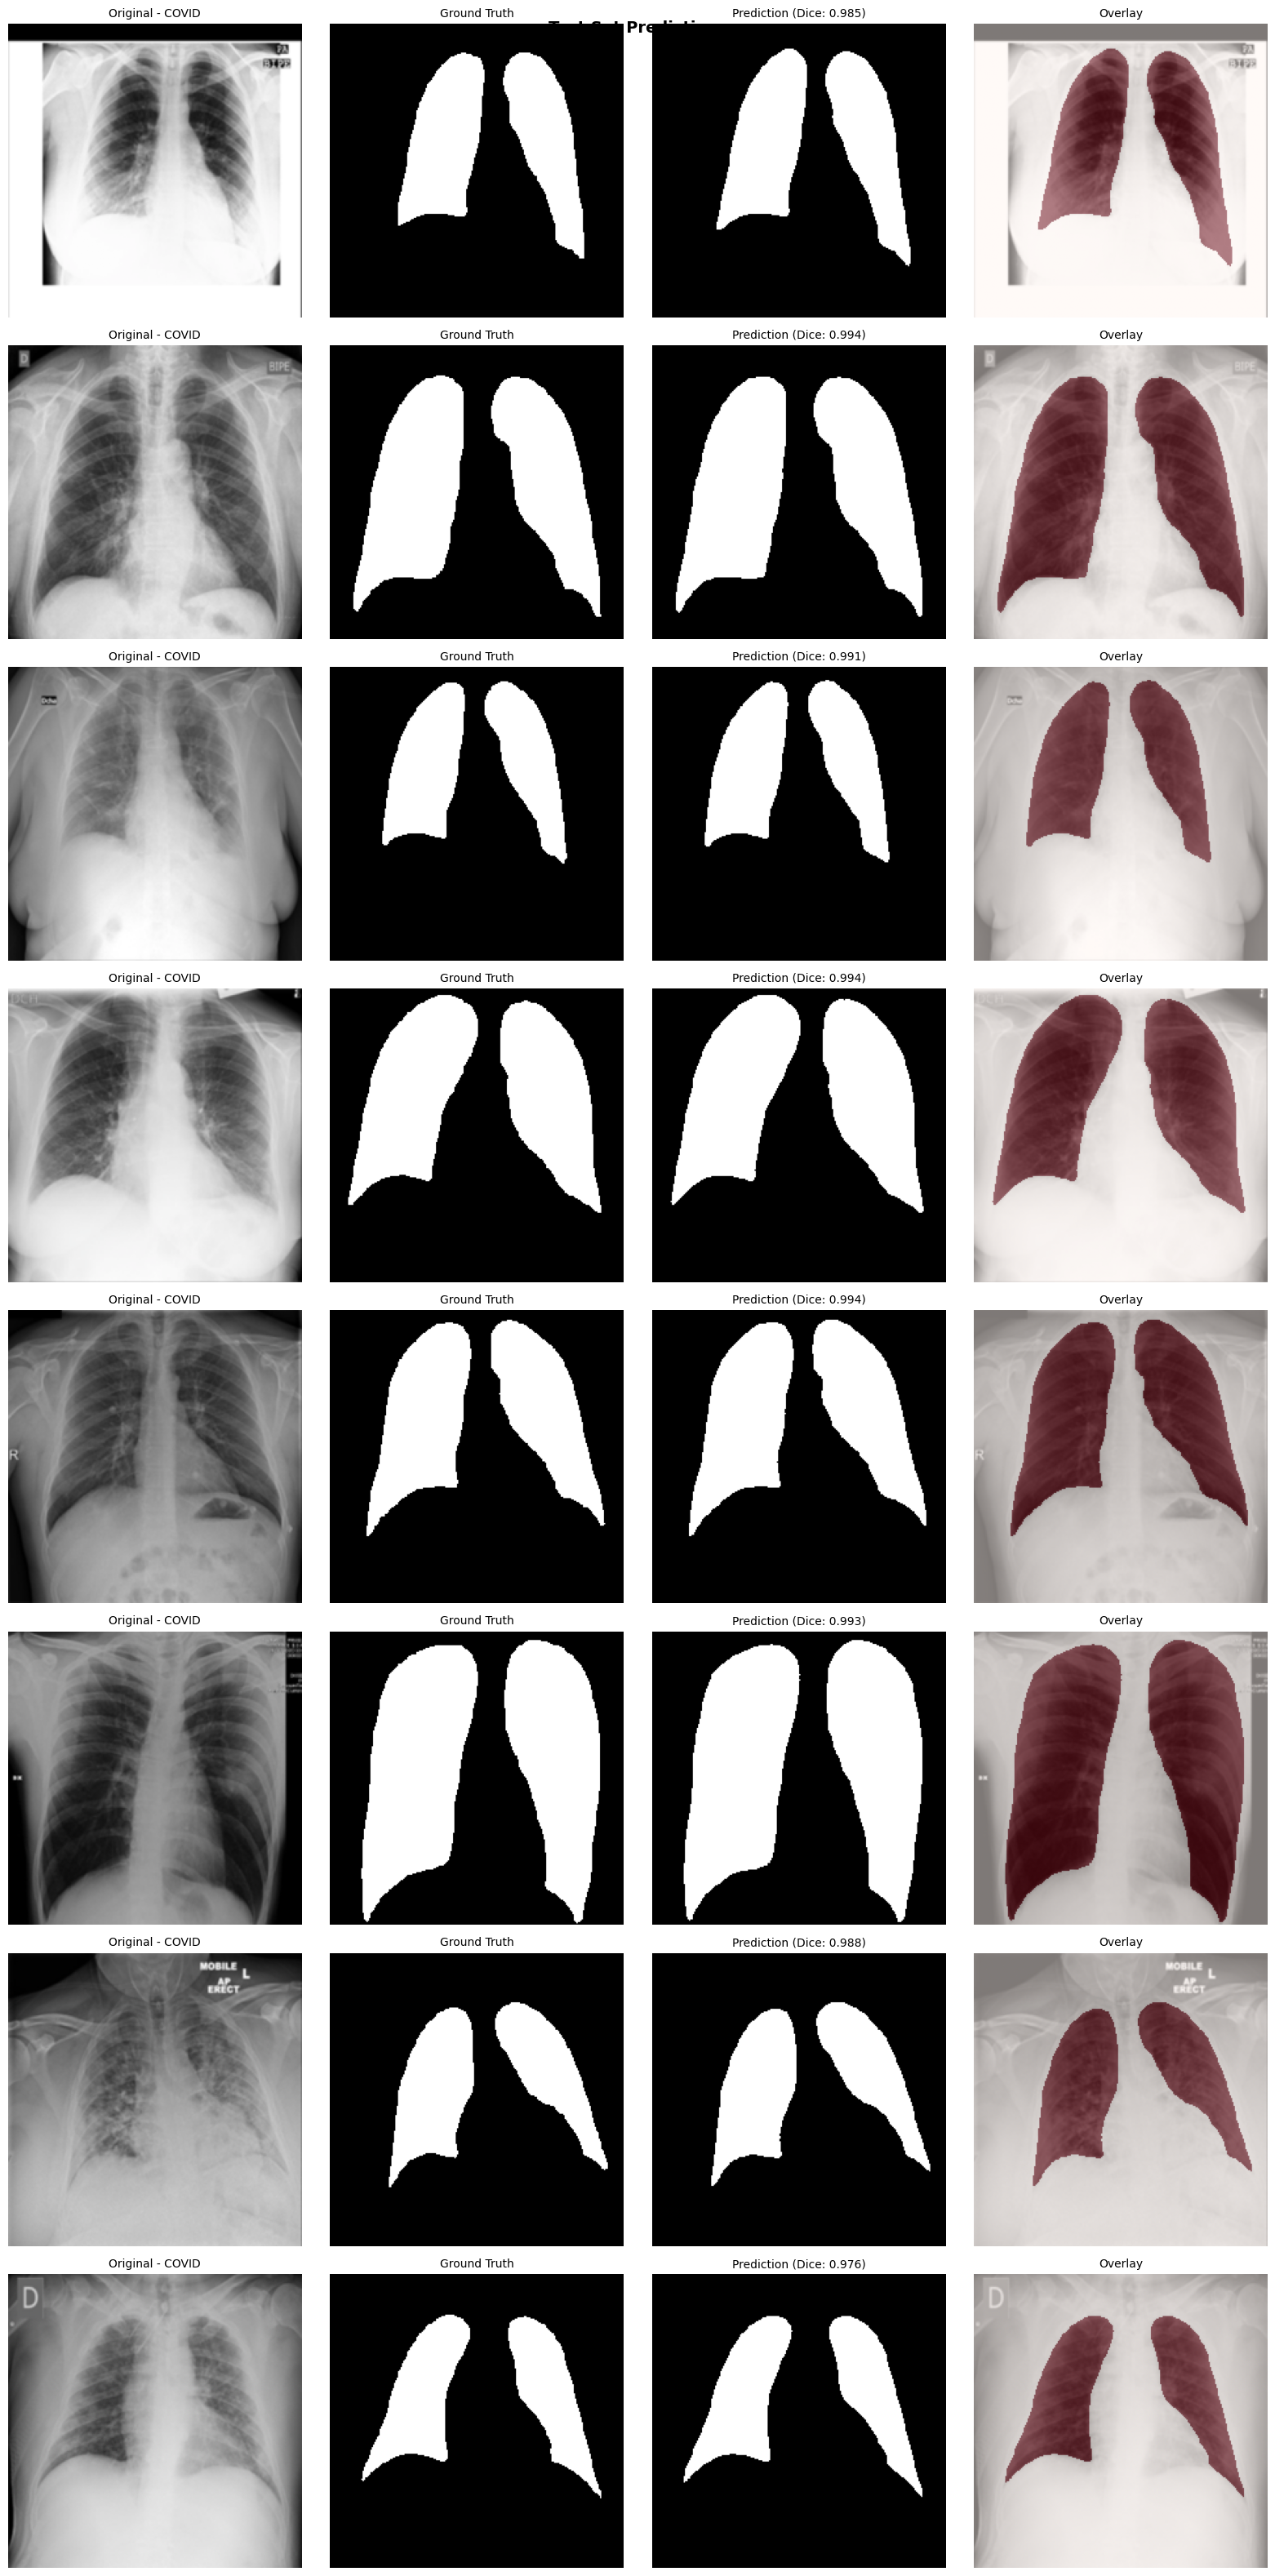

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import numpy as np
import random


class COVID19SegmentationDataset(Dataset):
    """
    COVID-19 Radiography Segmentation Dataset
    이미지와 마스크를 함께 로드하는 데이터셋
    """
    
    def __init__(self, root_dir, transform=None, split='train', train_ratio=0.8, random_seed=42):
        """
        Args:
            root_dir (str): 'COVID-19_Radiography_Dataset' 폴더 경로
            transform: transform 함수
            split (str): 'train', 'val', 'test' 중 하나
            train_ratio (float): 학습 데이터 비율
            random_seed (int): 랜덤 시드
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        # 클래스 정의
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 데이터 로드
        self.data = []
        
        np.random.seed(random_seed)
        
        for class_name in self.classes:
            # 메타데이터 파일 경로
            metadata_file = os.path.join(root_dir, f'{class_name}.metadata.xlsx')
            
            # 이미지 및 마스크 폴더 경로
            image_folder = os.path.join(root_dir, class_name, 'images')
            mask_folder = os.path.join(root_dir, class_name, 'masks')
            
            # 메타데이터 읽기
            if os.path.exists(metadata_file):
                df = pd.read_excel(metadata_file)
                file_names = df['FILE NAME'].values  # 확장자 없음
            else:
                # 메타데이터 파일이 없으면 폴더에서 직접 읽기
                file_names = [f.replace('.png', '') for f in os.listdir(image_folder) 
                            if f.endswith('.png')]
            
            # 데이터 분할
            n_samples = len(file_names)
            indices = np.random.permutation(n_samples)
            
            train_size = int(n_samples * train_ratio)
            val_size = int(n_samples * (1 - train_ratio) / 2)
            
            if split == 'train':
                selected_indices = indices[:train_size]
            elif split == 'val':
                selected_indices = indices[train_size:train_size + val_size]
            else:  # test
                selected_indices = indices[train_size + val_size:]
            
            # 선택된 파일들 추가
            not_found_count = 0
            for idx in selected_indices:
                file_name_from_excel = file_names[idx]
                
                # 여러 가지 파일명 형식 시도
                image_path = None
                mask_path = None
                
                # 1. 원본 그대로 (NORMAL-1)
                test_image = os.path.join(image_folder, f'{file_name_from_excel}.png')
                test_mask = os.path.join(mask_folder, f'{file_name_from_excel}.png')
                if os.path.exists(test_image) and os.path.exists(test_mask):
                    image_path = test_image
                    mask_path = test_mask
                
                # 2. Capitalize (Normal-1)
                if image_path is None:
                    parts = file_name_from_excel.split('-')
                    if len(parts) >= 2:
                        capitalized_name = f"{parts[0].capitalize()}-{'-'.join(parts[1:])}"
                        test_image = os.path.join(image_folder, f'{capitalized_name}.png')
                        test_mask = os.path.join(mask_folder, f'{capitalized_name}.png')
                        if os.path.exists(test_image) and os.path.exists(test_mask):
                            image_path = test_image
                            mask_path = test_mask
                
                # 3. 모두 소문자 (normal-1)
                if image_path is None:
                    lower_name = file_name_from_excel.lower()
                    test_image = os.path.join(image_folder, f'{lower_name}.png')
                    test_mask = os.path.join(mask_folder, f'{lower_name}.png')
                    if os.path.exists(test_image) and os.path.exists(test_mask):
                        image_path = test_image
                        mask_path = test_mask
                
                if image_path and mask_path:
                    self.data.append({
                        'image': image_path,
                        'mask': mask_path,
                        'class': class_name,
                        'class_idx': self.class_to_idx[class_name]
                    })
                else:
                    not_found_count += 1
            
            if not_found_count > 0:
                print(f"  [{class_name}] {not_found_count}개 파일을 찾을 수 없습니다.")
        
        print(f"{split.upper()} 데이터셋 로드 완료: {len(self.data)}개 샘플")
        self._print_class_distribution()
    
    def _print_class_distribution(self):
        """클래스별 데이터 분포 출력"""
        class_counts = {cls: 0 for cls in self.classes}
        for item in self.data:
            class_counts[item['class']] += 1
        
        print(f"클래스별 분포:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}개")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 이미지 로드 (RGB)
        image = Image.open(item['image']).convert('RGB')
        
        # 마스크 로드 (Grayscale)
        mask = Image.open(item['mask']).convert('L')
        
        # Transform 적용
        if self.transform:
            image, mask = self.transform(image, mask)
        
        class_idx = item['class_idx']
        
        return image, mask, class_idx


class SegmentationTransform:
    """
    이미지와 마스크에 동일한 변환을 적용하는 Transform 클래스
    """
    
    def __init__(self, image_size=256, augment=True):
        self.image_size = image_size
        self.augment = augment
        
        # 이미지 정규화
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, [self.image_size, self.image_size])
        mask = TF.resize(mask, [self.image_size, self.image_size], 
                        interpolation=transforms.InterpolationMode.NEAREST)
        
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            # Random vertical flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            # Random rotation
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            
            # Color jitter (이미지만)
            if random.random() > 0.5:
                image = transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2
                )(image)
        
        # ToTensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # 마스크 이진화
        mask = (mask > 0.5).float()
        
        # 이미지 정규화
        image = self.normalize(image)
        
        # 마스크는 [1, H, W] -> [H, W]로 변환
        mask = mask.squeeze(0)
        
        return image, mask


def create_segmentation_dataloaders(root_dir, batch_size=16, image_size=256,
                                   train_ratio=0.8, num_workers=4, random_seed=42):
    """
    Segmentation DataLoader 생성 함수
    
    Args:
        root_dir (str): 데이터셋 루트 경로
        batch_size (int): 배치 크기
        image_size (int): 이미지 크기
        train_ratio (float): 학습 데이터 비율
        num_workers (int): 데이터 로딩 워커 수
        random_seed (int): 랜덤 시드
    
    Returns:
        train_loader, val_loader, test_loader
    """
    # Transform 생성
    train_transform = SegmentationTransform(image_size=image_size, augment=True)
    val_transform = SegmentationTransform(image_size=image_size, augment=False)
    
    # Dataset 생성
    train_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        transform=train_transform,
        split='train',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    val_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        transform=val_transform,
        split='val',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    test_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        transform=val_transform,
        split='test',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    # DataLoader 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

class COVID19SegmentationDataset(Dataset):
    """
    COVID-19 Radiography Segmentation Dataset
    이미지와 마스크를 함께 로드하는 데이터셋
    """
    
    def __init__(self, root_dir, transform=None, split='train', train_ratio=0.8, random_seed=42):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        # 클래스 정의
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 데이터 로드
        self.data = []
        
        np.random.seed(random_seed)
        
        for class_name in self.classes:
            # 메타데이터 파일 경로
            metadata_file = os.path.join(root_dir, f'{class_name}.metadata.xlsx')
            
            # 이미지 및 마스크 폴더 경로
            image_folder = os.path.join(root_dir, class_name, 'images')
            mask_folder = os.path.join(root_dir, class_name, 'masks')
            
            # 메타데이터 읽기
            if os.path.exists(metadata_file):
                df = pd.read_excel(metadata_file)
                file_names = df['FILE NAME'].values
            else:
                file_names = [f.replace('.png', '') for f in os.listdir(image_folder) 
                            if f.endswith('.png')]
            
            # 데이터 분할
            n_samples = len(file_names)
            indices = np.random.permutation(n_samples)
            
            train_size = int(n_samples * train_ratio)
            val_size = int(n_samples * (1 - train_ratio) / 2)
            
            if split == 'train':
                selected_indices = indices[:train_size]
            elif split == 'val':
                selected_indices = indices[train_size:train_size + val_size]
            else:  # test
                selected_indices = indices[train_size + val_size:]
            
            # 선택된 파일들 추가
            not_found_count = 0
            for idx in selected_indices:
                file_name_from_excel = file_names[idx]
                
                # 여러 가지 파일명 형식 시도
                image_path = None
                mask_path = None
                
                # 1. 원본 그대로
                test_image = os.path.join(image_folder, f'{file_name_from_excel}.png')
                test_mask = os.path.join(mask_folder, f'{file_name_from_excel}.png')
                if os.path.exists(test_image) and os.path.exists(test_mask):
                    image_path = test_image
                    mask_path = test_mask
                
                # 2. Capitalize
                if image_path is None:
                    parts = file_name_from_excel.split('-')
                    if len(parts) >= 2:
                        capitalized_name = f"{parts[0].capitalize()}-{'-'.join(parts[1:])}"
                        test_image = os.path.join(image_folder, f'{capitalized_name}.png')
                        test_mask = os.path.join(mask_folder, f'{capitalized_name}.png')
                        if os.path.exists(test_image) and os.path.exists(test_mask):
                            image_path = test_image
                            mask_path = test_mask
                
                # 3. 모두 소문자
                if image_path is None:
                    lower_name = file_name_from_excel.lower()
                    test_image = os.path.join(image_folder, f'{lower_name}.png')
                    test_mask = os.path.join(mask_folder, f'{lower_name}.png')
                    if os.path.exists(test_image) and os.path.exists(test_mask):
                        image_path = test_image
                        mask_path = test_mask
                
                if image_path and mask_path:
                    self.data.append({
                        'image': image_path,
                        'mask': mask_path,
                        'class': class_name,
                        'class_idx': self.class_to_idx[class_name]
                    })
                else:
                    not_found_count += 1
            
            if not_found_count > 0:
                print(f"  [{class_name}] {not_found_count}개 파일을 찾을 수 없습니다.")
        
        print(f"{split.upper()} 데이터셋 로드 완료: {len(self.data)}개 샘플")
        self._print_class_distribution()
    
    def _print_class_distribution(self):
        """클래스별 데이터 분포 출력"""
        class_counts = {cls: 0 for cls in self.classes}
        for item in self.data:
            class_counts[item['class']] += 1
        
        print(f"클래스별 분포:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}개")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 이미지 로드 (RGB)
        image = Image.open(item['image']).convert('RGB')
        
        # 마스크 로드 (Grayscale)
        mask = Image.open(item['mask']).convert('L')
        
        # Transform 적용
        if self.transform:
            image, mask = self.transform(image, mask)
        
        class_idx = item['class_idx']
        
        return image, mask, class_idx


class SegmentationTransform:
    """
    이미지와 마스크에 동일한 변환을 적용하는 Transform 클래스
    """
    
    def __init__(self, image_size=256, augment=True):
        self.image_size = image_size
        self.augment = augment
        
        # 이미지 정규화
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, [self.image_size, self.image_size])
        mask = TF.resize(mask, [self.image_size, self.image_size], 
                        interpolation=transforms.InterpolationMode.NEAREST)
        
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            # Random vertical flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            
            # Random rotation
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            
            # Color jitter (이미지만)
            if random.random() > 0.5:
                image = transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2
                )(image)
        
        # ToTensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # 마스크 이진화
        mask = (mask > 0.5).float()
        
        # 이미지 정규화
        image = self.normalize(image)
        
        # 마스크는 [1, H, W] -> [H, W]로 변환
        mask = mask.squeeze(0)
        
        return image, mask


def create_segmentation_dataloaders(root_dir, batch_size=16, image_size=256,
                                   train_ratio=0.8, num_workers=4, random_seed=42):
    """
    Segmentation DataLoader 생성 함수
    """
    # Transform 생성
    train_transform = SegmentationTransform(image_size=image_size, augment=True)
    val_transform = SegmentationTransform(image_size=image_size, augment=False)
    
    # Dataset 생성
    train_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        transform=train_transform,
        split='train',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    val_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        transform=val_transform,
        split='val',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    test_dataset = COVID19SegmentationDataset(
        root_dir=root_dir,
        transform=val_transform,
        split='test',
        train_ratio=train_ratio,
        random_seed=random_seed
    )
    
    # DataLoader 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader


# ==========================================
# 모델 정의
# ==========================================

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """Standard U-Net architecture"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class UNetResNet(nn.Module):
    """U-Net with ResNet encoder (pretrained)"""
    def __init__(self, n_classes=1, pretrained=True):
        super(UNetResNet, self).__init__()
        
        # ResNet34 encoder
        resnet = models.resnet34(pretrained=pretrained)
        
        # Encoder
        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4
        
        self.pool = resnet.maxpool
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(512, 256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(256, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(128, 64)
        
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        
        # Final output
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc1_pooled = self.pool(enc1)
        
        enc2 = self.encoder2(enc1_pooled)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        
        # Decoder
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.outc(dec1)
        
        return out


class AttentionBlock(nn.Module):
    """Attention block for U-Net"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUNet(nn.Module):
    """Attention U-Net for better feature localization"""
    def __init__(self, n_channels=3, n_classes=1):
        super(AttentionUNet, self).__init__()
        
        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder with attention
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.upconv1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.upconv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.upconv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.upconv4 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder with attention
        d1 = self.up1(x5)
        x4 = self.att1(g=d1, x=x4)
        d1 = torch.cat([x4, d1], dim=1)
        d1 = self.upconv1(d1)
        
        d2 = self.up2(d1)
        x3 = self.att2(g=d2, x=x3)
        d2 = torch.cat([x3, d2], dim=1)
        d2 = self.upconv2(d2)
        
        d3 = self.up3(d2)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.cat([x2, d3], dim=1)
        d3 = self.upconv3(d3)
        
        d4 = self.up4(d3)
        x1 = self.att4(g=d4, x=x1)
        d4 = torch.cat([x1, d4], dim=1)
        d4 = self.upconv4(d4)
        
        out = self.outc(d4)
        
        return out


def get_model(model_name='unet', n_channels=3, n_classes=1, pretrained=True):
    """모델 생성 함수"""
    if model_name == 'unet':
        model = UNet(n_channels=n_channels, n_classes=n_classes)
    elif model_name == 'unet_resnet':
        model = UNetResNet(n_classes=n_classes, pretrained=pretrained)
    elif model_name == 'attention_unet':
        model = AttentionUNet(n_channels=n_channels, n_classes=n_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model


# ==========================================
# Loss 함수
# ==========================================

class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice


class DiceBCELoss(nn.Module):
    """Combination of Dice Loss and BCE Loss"""
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super(DiceBCELoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        dice_loss = self.dice(pred, target)
        bce_loss = self.bce(pred, target)
        
        return self.weight_dice * dice_loss + self.weight_bce * bce_loss


class IoULoss(nn.Module):
    """IoU Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super(IoULoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        return 1 - iou


class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, pred, target):
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        return focal_loss.mean()


def get_loss_function(loss_name='dice_bce'):
    """Loss 함수 생성"""
    if loss_name == 'dice':
        return DiceLoss()
    elif loss_name == 'bce':
        return nn.BCEWithLogitsLoss()
    elif loss_name == 'dice_bce':
        return DiceBCELoss()
    elif loss_name == 'iou':
        return IoULoss()
    elif loss_name == 'focal':
        return FocalLoss()
    else:
        raise ValueError(f"Unknown loss: {loss_name}")

# 사용 예시
if __name__ == "__main__":
    # 데이터셋 경로
    root_dir = 'COVID-19_Radiography_Dataset'
    
    # DataLoader 생성
    train_loader, val_loader, test_loader = create_segmentation_dataloaders(
        root_dir=root_dir,
        batch_size=16,
        image_size=256,
        train_ratio=0.8,
        num_workers=4
    )
    
    # 데이터 확인
    print("\n=== Segmentation 데이터 로더 정보 ===")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    # 샘플 배치 확인
    images, masks, class_indices = next(iter(train_loader))
    print(f"\n이미지 배치 shape: {images.shape}")
    print(f"마스크 배치 shape: {masks.shape}")
    print(f"클래스 인덱스 shape: {class_indices.shape}")
    print(f"이미지 범위: [{images.min():.3f}, {images.max():.3f}]")
    print(f"마스크 범위: [{masks.min():.3f}, {masks.max():.3f}]")
    print(f"클래스 인덱스 예시: {class_indices[:5]}")
    
    # 클래스 이름 매핑
    idx_to_class = {v: k for k, v in train_loader.dataset.class_to_idx.items()}
    print(f"\n클래스 매핑: {idx_to_class}")
    
    # 마스크 통계
    print(f"\n마스크 통계:")
    print(f"  평균 마스크 영역 비율: {masks.mean():.4f}")
    print(f"  마스크가 있는 픽셀 수: {(masks > 0.5).sum()}")

# 모델 로드 및 테스트
def evaluate_test_set():
    # Device 설정
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # 데이터 로더 생성
    print("Loading test dataset...")
    _, _, test_loader = create_segmentation_dataloaders(
        root_dir='COVID-19_Radiography_Dataset',
        batch_size=16,
        image_size=224,
        train_ratio=0.8,
        num_workers=4
    )
    print(f"Test batches: {len(test_loader)}\n")
    
    # 모델 생성
    print("Creating model...")
    model = get_model('unet', n_channels=3, n_classes=1)
    
    # 체크포인트 로드
    print("Loading best model from seg_results/best_model.pth...")
    checkpoint = torch.load('seg_results/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Best model from Epoch {checkpoint['epoch']}")
    print(f"Best Val Dice: {checkpoint['best_val_dice']:.4f}\n")
    
    # Loss 함수
    criterion = get_loss_function('dice_bce')
    
    # 테스트
    print("="*80)
    print("Testing on Test Set...")
    print("="*80)
    
    test_loss = 0.0
    test_dice = 0.0
    test_iou = 0.0
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Testing')
        for images, masks, class_indices in pbar:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Metrics 계산
            pred = torch.sigmoid(outputs)
            pred = (pred > 0.5).float()
            target = masks.float()
            
            # Dice
            intersection = (pred * target).sum()
            dice = (2. * intersection + 1e-7) / (pred.sum() + target.sum() + 1e-7)
            
            # IoU
            union = pred.sum() + target.sum() - intersection
            iou = (intersection + 1e-7) / (union + 1e-7)
            
            test_loss += loss.item()
            test_dice += dice.item()
            test_iou += iou.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice.item():.4f}',
                'iou': f'{iou.item():.4f}'
            })
    
    test_loss /= len(test_loader)
    test_dice /= len(test_loader)
    test_iou /= len(test_loader)
    
    # 결과 출력
    print("\n" + "="*80)
    print(f"{'Test Set Results':^80}")
    print("="*80)
    print(f"Loss:       {test_loss:.4f}")
    print(f"Dice Score: {test_dice:.4f}")
    print(f"IoU:        {test_iou:.4f}")
    print("="*80)
    
    # 시각화
    print("\nGenerating test predictions visualization...")
    visualize_test_predictions(model, test_loader, device)
    
    return test_loss, test_dice, test_iou


def visualize_test_predictions(model, test_loader, device, num_samples=8):
    """테스트 예측 시각화 (8개 샘플)"""
    model.eval()
    
    images_list = []
    masks_list = []
    preds_list = []
    class_indices_list = []
    
    with torch.no_grad():
        for images, masks, class_indices in test_loader:
            images = images.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            
            images_list.append(images.cpu())
            masks_list.append(masks.cpu())
            preds_list.append(preds.squeeze(1).cpu())
            class_indices_list.append(class_indices.cpu())
            
            if len(images_list) * images.size(0) >= num_samples:
                break
    
    images_all = torch.cat(images_list, dim=0)[:num_samples]
    masks_all = torch.cat(masks_list, dim=0)[:num_samples]
    preds_all = torch.cat(preds_list, dim=0)[:num_samples]
    class_indices_all = torch.cat(class_indices_list, dim=0)[:num_samples]
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    idx_to_class = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
    
    for i in range(num_samples):
        # Denormalize image
        img = images_all[i] * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        mask = masks_all[i].numpy()
        pred = preds_all[i].numpy()
        class_name = idx_to_class[class_indices_all[i].item()]
        
        # Calculate Dice
        intersection = (pred * mask).sum()
        dice = (2. * intersection) / (pred.sum() + mask.sum() + 1e-7)
        
        # Original Image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original - {class_name}', fontsize=10)
        axes[i, 0].axis('off')
        
        # Ground Truth
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=10)
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f'Prediction (Dice: {dice:.3f})', fontsize=10)
        axes[i, 2].axis('off')
        
        # Overlay
        axes[i, 3].imshow(img)
        axes[i, 3].imshow(pred, cmap='Reds', alpha=0.5)
        axes[i, 3].set_title('Overlay', fontsize=10)
        axes[i, 3].axis('off')
    
    plt.suptitle('Test Set Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('seg_results_filtered/test_predictions.png', dpi=150, bbox_inches='tight')
    print("Saved: seg_results_filtered/test_predictions.png")
    plt.show()


# 실행
test_loss, test_dice, test_iou = evaluate_test_set()

In [14]:
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
import numpy as np

# ==========================================
# 모델 정의
# ==========================================

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """Standard U-Net architecture"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

def precompute_segmented_images(seg_model, device, root_dir='COVID-19_Radiography_Dataset'):
    """
    모든 이미지에 대해 분할 마스크를 적용한 이미지를 미리 생성하여 저장
    
    저장 구조:
    COVID-19_Radiography_Dataset/
    ├── COVID/
    │   ├── images/
    │   ├── masks/
    │   └── segments/  ← 여기에 저장
    ├── Lung_Opacity/
    │   ├── images/
    │   ├── masks/
    │   └── segments/  ← 여기에 저장
    ...
    """
    
    seg_model.eval()
    
    # Segmentation용 transform
    seg_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    print("="*80)
    print("Precomputing Segmented Images")
    print("="*80)
    print(f"Root directory: {root_dir}")
    print(f"Device: {device}\n")
    
    total_processed = 0
    total_failed = 0
    
    for class_name in classes:
        print(f"\n{'='*80}")
        print(f"Processing class: {class_name}")
        print(f"{'='*80}")
        
        # 경로 설정
        image_folder = os.path.join(root_dir, class_name, 'images')
        segments_folder = os.path.join(root_dir, class_name, 'segments')
        
        # segments 폴더 생성
        os.makedirs(segments_folder, exist_ok=True)
        print(f"Output directory: {segments_folder}")
        
        # 디렉토리에서 직접 로드
        file_names = [f.replace('.png', '') for f in os.listdir(image_folder) 
                     if f.endswith('.png')]
        print(f"Found {len(file_names)} files from directory")
        
        processed = 0
        failed = 0
        
        for file_name in tqdm(file_names, desc=f'{class_name}'):
            try:
                # 이미지 경로 찾기 (대소문자 처리)
                image_path = find_image_path(image_folder, file_name)
                
                if image_path is None:
                    failed += 1
                    continue
                
                # 이미지 로드
                image = Image.open(image_path).convert('RGB')
                image_resized = image.resize((224, 224))
                
                # 마스크 생성
                with torch.no_grad():
                    img_tensor = seg_transform(image_resized).unsqueeze(0).to(device)
                    output = seg_model(img_tensor)
                    mask = torch.sigmoid(output)
                    mask = (mask > 0.5).float()
                    
                    # [1, 1, H, W] -> [H, W]
                    mask = mask.squeeze().cpu()
                    
                
                # 마스크 적용
                image_np = np.array(image_resized).astype(np.float32)
                mask_3ch = np.stack([mask] * 3, axis=-1)
                segmented_image = image_np * mask_3ch
                segmented_image = segmented_image.astype(np.uint8)
                
                # PIL Image로 변환
                segmented_pil = Image.fromarray(segmented_image)
                
                # 저장 (원본 파일명과 동일하게)
                # 대소문자 처리된 파일명 추출
                actual_filename = os.path.basename(image_path)
                save_path = os.path.join(segments_folder, actual_filename)
                segmented_pil.save(save_path)
                
                processed += 1
                
            except Exception as e:
                print(f"\nError processing {file_name}: {str(e)}")
                failed += 1
        
        print(f"\n{class_name} Summary:")
        print(f"  Processed: {processed}")
        print(f"  Failed: {failed}")
        
        total_processed += processed
        total_failed += failed
    
    print(f"\n{'='*80}")
    print(f"{'Precomputation Complete!':^80}")
    print(f"{'='*80}")
    print(f"Total processed: {total_processed}")
    print(f"Total failed: {total_failed}")
    print(f"{'='*80}\n")


def find_image_path(folder, file_name):
    """파일명 찾기 (대소문자 처리)"""
    # 1. 원본 그대로
    path = os.path.join(folder, f'{file_name}.png')
    if os.path.exists(path):
        return path
    
    # 2. Capitalize
    parts = file_name.split('-')
    if len(parts) >= 2:
        capitalized = f"{parts[0].capitalize()}-{'-'.join(parts[1:])}"
        path = os.path.join(folder, f'{capitalized}.png')
        if os.path.exists(path):
            return path
    
    # 3. 소문자
    path = os.path.join(folder, f'{file_name.lower()}.png')
    if os.path.exists(path):
        return path
    
    return None


# ==========================================
# 실행
# ==========================================

if __name__ == "__main__":
    import gc
    
    # GPU 메모리 클리어
    torch.cuda.empty_cache()
    gc.collect()
    
    # Device 설정
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Segmentation 모델 로드
    print("Loading Segmentation Model...")
    seg_model = UNet(n_channels=3, n_classes=1)
    checkpoint = torch.load('seg_results_filtered/best_model.pth')
    seg_model.load_state_dict(checkpoint['model_state_dict'])
    seg_model = seg_model.to(device)
    seg_model.eval()
    print("Model loaded successfully!\n")
    
    # 분할 이미지 생성
    precompute_segmented_images(
        seg_model=seg_model,
        device=device,
        root_dir='COVID-19_Radiography_Dataset'
    )

Using device: cuda:0

Loading Segmentation Model...
Model loaded successfully!

Precomputing Segmented Images
Root directory: COVID-19_Radiography_Dataset
Device: cuda:0


Processing class: COVID
Output directory: COVID-19_Radiography_Dataset/COVID/segments
Found 3569 files from directory


COVID: 100%|██████████| 3569/3569 [00:59<00:00, 60.27it/s]



COVID Summary:
  Processed: 3569
  Failed: 0

Processing class: Lung_Opacity
Output directory: COVID-19_Radiography_Dataset/Lung_Opacity/segments
Found 6011 files from directory


Lung_Opacity: 100%|██████████| 6011/6011 [01:37<00:00, 61.61it/s]



Lung_Opacity Summary:
  Processed: 6011
  Failed: 0

Processing class: Normal
Output directory: COVID-19_Radiography_Dataset/Normal/segments
Found 10190 files from directory


Normal: 100%|██████████| 10190/10190 [02:49<00:00, 60.27it/s]



Normal Summary:
  Processed: 10190
  Failed: 0

Processing class: Viral Pneumonia
Output directory: COVID-19_Radiography_Dataset/Viral Pneumonia/segments
Found 1514 files from directory


Viral Pneumonia: 100%|██████████| 1514/1514 [00:28<00:00, 53.41it/s]


Viral Pneumonia Summary:
  Processed: 1514
  Failed: 0

                            Precomputation Complete!                            
Total processed: 21284
Total failed: 0



In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import hashlib
from collections import defaultdict
import cv2

def compute_file_hash(file_path):
    """완전 중복 파일 체크용 (MD5)"""
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def compute_image_hash(image_path, hash_size=16):
    """이미지 해시 계산 (유사 이미지 그룹핑용)"""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        
        # Resize to hash_size x hash_size
        resized = cv2.resize(img, (hash_size, hash_size), interpolation=cv2.INTER_AREA)
        
        # Average hash
        avg = resized.mean()
        diff = resized > avg
        
        # Convert to hash string
        hash_str = ''.join(['1' if b else '0' for b in diff.flatten()])
        return hash_str
    except:
        return None


def process_duplicates_and_similar(root_dir, classes, use_segmented=True):
    """
    1단계: 완전 중복 제거 (하나만 남김)
    2단계: 유사 이미지 그룹핑 (같은 split에 배치)
    
    Args:
        use_segmented: True면 segments 폴더만, False면 images 폴더만 사용
    """
    folder_name = 'segments' if use_segmented else 'images'  # 먼저 선택!
    
    print("\n" + "="*80)
    print("Step 1: Detecting exact duplicates...")
    print(f"Using folder: {folder_name}")  # 어떤 폴더 쓰는지 출력
    print("="*80)
    
    # 1단계: 완전 중복 찾기
    file_hash_to_files = defaultdict(list)
    
    for class_name in classes:
        folder_path = os.path.join(root_dir, class_name, folder_name)  # 선택된 폴더만!
        
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} does not exist, skipping...")
            continue
        
        files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        
        for file_name in tqdm(files, desc=f'{class_name}/{folder_name}', leave=False):
            file_path = os.path.join(folder_path, file_name)
            file_hash = compute_file_hash(file_path)
            
            file_hash_to_files[file_hash].append({
                'path': file_path,
                'class': class_name,
                'filename': file_name
            })
    
    # 완전 중복 통계
    exact_duplicates = {k: v for k, v in file_hash_to_files.items() if len(v) > 1}
    total_exact_dups = sum(len(v) - 1 for v in exact_duplicates.values())
    
    print(f"\n✓ Total files: {len(file_hash_to_files)}")
    print(f"✓ Exact duplicate groups: {len(exact_duplicates)}")
    print(f"✓ Files to remove (exact duplicates): {total_exact_dups}")
    
    # 각 그룹에서 첫 번째만 유지
    unique_files = []
    for files in file_hash_to_files.values():
        unique_files.append(files[0])  # 첫 번째만
    
    print(f"✓ Unique files after deduplication: {len(unique_files)}")
    
    # 2단계: 유사 이미지 그룹핑
    print("\n" + "="*80)
    print("Step 2: Grouping similar images...")
    print("="*80)
    
    image_hash_to_files = defaultdict(list)
    
    for file_info in tqdm(unique_files, desc='Computing similarity hashes'):
        img_hash = compute_image_hash(file_info['path'])
        if img_hash:
            image_hash_to_files[img_hash].append(file_info)
    
    # 유사 이미지 그룹 통계
    similar_groups = {k: v for k, v in image_hash_to_files.items() if len(v) > 1}
    
    print(f"\n✓ Unique similarity hashes: {len(image_hash_to_files)}")
    print(f"✓ Similar image groups: {len(similar_groups)}")
    print(f"✓ Total images in similar groups: {sum(len(v) for v in similar_groups.values())}")
    
    if len(similar_groups) > 0:
        print("\nSimilar image examples:")
        for i, (hash_val, files) in enumerate(list(similar_groups.items())[:3]):
            print(f"  Group {i+1}: {len(files)} similar images")
            for f in files[:2]:
                print(f"    - {f['class']}/{f['filename']}")
    
    print("="*80 + "\n")
    
    return image_hash_to_files

def deduplicate_image_groups(hash_to_files, keep='first'):
    """
    중복 이미지 그룹에서 하나만 남기고 제거
    
    Args:
        hash_to_files: group_duplicate_images()의 반환값
        keep: 'first', 'shortest_path' 중 선택
    
    Returns:
        deduplicated_hash_to_files: 각 그룹당 1개만 있는 dict
    """
    deduplicated = {}
    
    for hash_val, files in hash_to_files.items():
        if keep == 'first':
            selected = files[0]
        elif keep == 'shortest_path':
            selected = min(files, key=lambda x: len(x['path']))
        else:
            selected = files[0]
        
        # 각 해시당 1개만 남김
        deduplicated[hash_val] = [selected]
    
    return deduplicated

def split_data_with_duplicate_grouping(hash_to_files, train_ratio=0.7, val_ratio=0.15, random_seed=42):
    """
    중복 이미지를 같은 split에 배치하면서 데이터 분할
    
    Returns:
        train_files, val_files, test_files (list of file info dicts)
    """
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    # 각 해시 그룹을 하나의 단위로 취급
    hash_groups = list(hash_to_files.values())
    random.shuffle(hash_groups)
    
    # 클래스별로 분리
    class_groups = defaultdict(list)
    for group in hash_groups:
        class_name = group[0]['class']  # 그룹 내 첫 번째 파일의 클래스
        class_groups[class_name].append(group)
    
    train_files = []
    val_files = []
    test_files = []
    
    # 클래스별로 분할
    for class_name, groups in class_groups.items():
        n_groups = len(groups)
        
        train_end = int(n_groups * train_ratio)
        val_end = int(n_groups * (train_ratio + val_ratio))
        
        # 각 split에 그룹 전체를 할당
        for group in groups[:train_end]:
            train_files.extend(group)
        
        for group in groups[train_end:val_end]:
            val_files.extend(group)
        
        for group in groups[val_end:]:
            test_files.extend(group)
    
    return train_files, val_files, test_files


def get_classification_transforms(image_size=224, augment=True):
    """분류 모델용 transform"""
    if augment:
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                fill=0
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    
    return transform


class PrecomputedSegmentedDataset(Dataset):
    """
    디렉토리에서 직접 이미지를 로드하는 데이터셋
    중복 이미지는 같은 split에 배치됨
    """
    
    def __init__(
        self, 
        file_list,
        transform=None,
        classes=None
    ):
        """
        Args:
            file_list: 파일 정보 리스트 [{'path': ..., 'class': ..., 'filename': ...}, ...]
            transform: 이미지 변환
            classes: 클래스 리스트
        """
        self.data = file_list
        self.transform = transform
        self.classes = classes or ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self._print_class_distribution()
    
    def _print_class_distribution(self):
        """클래스별 분포 출력"""
        class_counts = {cls: 0 for cls in self.classes}
        for item in self.data:
            class_counts[item['class']] += 1
        
        print(f"  클래스별 분포:")
        for cls, count in class_counts.items():
            print(f"    {cls}: {count}개")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 이미지 로드
        image = Image.open(item['path']).convert('RGB')
        
        # Transform 적용
        if self.transform:
            image = self.transform(image)
        
        label = self.class_to_idx[item['class']]
        
        return image, label


def create_precomputed_dataloaders(
    root_dir,
    batch_size=32,
    image_size=224,
    num_workers=4,
    train_ratio=0.7,
    val_ratio=0.15,
    random_seed=42,
    use_segmented=True
):
    """
    디렉토리에서 직접 데이터를 로드하고 중복 이미지를 고려한 DataLoader 생성
    """
    
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    # 1. 중복 이미지 그룹핑
    hash_to_files = process_duplicates_and_similar(root_dir, 
                                                   classes,
                                                  use_segmented=use_segmented)
    
    # 2. 중복을 고려한 데이터 분할
    print("Splitting data (keeping duplicates together)...")
    train_files, val_files, test_files = split_data_with_duplicate_grouping(
        hash_to_files,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        random_seed=random_seed
    )
    
    print(f"\n{'='*80}")
    print(f"Data split completed:")
    print(f"  Train: {len(train_files)} samples")
    print(f"  Val:   {len(val_files)} samples")
    print(f"  Test:  {len(test_files)} samples")
    print(f"{'='*80}\n")
    
    # 3. Transform
    train_transform = get_classification_transforms(image_size, augment=True)
    val_transform = get_classification_transforms(image_size, augment=False)
    
    # 4. Dataset 생성
    print("="*80)
    print("TRAIN Dataset")
    print("="*80)
    train_dataset = PrecomputedSegmentedDataset(
        file_list=train_files,
        transform=train_transform,
        classes=classes
    )
    
    print("\n" + "="*80)
    print("VAL Dataset")
    print("="*80)
    val_dataset = PrecomputedSegmentedDataset(
        file_list=val_files,
        transform=val_transform,
        classes=classes
    )
    
    print("\n" + "="*80)
    print("TEST Dataset")
    print("="*80)
    test_dataset = PrecomputedSegmentedDataset(
        file_list=test_files,
        transform=val_transform,
        classes=classes
    )
    
    # 5. DataLoader 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader


# ==========================================
# 분류 모델 (동일)
# ==========================================

class COVID19Classifier(nn.Module):
    """ResNet 기반 COVID-19 분류 모델"""
    
    def __init__(self, num_classes=4, pretrained=True):
        super(COVID19Classifier, self).__init__()
        
        # ResNet50 백본
        if pretrained:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # 마지막 FC layer 교체
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


# Focal Loss로 변경 (어려운 샘플에 집중)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


# ==========================================
# Trainer 클래스 (동일)
# ==========================================

class ClassificationTrainer:
    """분류 모델 학습 클래스"""
    
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        save_dir='clf_results',
        class_names=None
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.save_dir = save_dir
        self.class_names = class_names or ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        
        os.makedirs(save_dir, exist_ok=True)
        
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'lr': []
        }
        
        self.best_val_loss = np.inf
        self.best_epoch = 0
    
    def train_epoch(self, epoch):
        """1 Epoch 학습"""
        self.model.train()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch:03d} [TRAIN]', ncols=120)
        
        for images, labels in pbar:
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Metrics
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            running_loss += loss.item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%',
                'lr': f'{self.optimizer.param_groups[0]["lr"]:.6f}'
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, epoch):
        """1 Epoch 검증"""
        self.model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_preds = []
        all_labels = []
        
        pbar = tqdm(self.val_loader, desc=f'Epoch {epoch:03d} [VAL]  ', ncols=120)
        
        with torch.no_grad():
            for images, labels in pbar:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                running_loss += loss.item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.*correct/total:.2f}%'
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_preds, all_labels
    
    def save_checkpoint(self, epoch, is_best=False):
        """체크포인트 저장"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_loss': self.best_val_loss,
            'history': self.history
        }
        
        torch.save(checkpoint, os.path.join(self.save_dir, 'last_checkpoint.pth'))
        
        if is_best:
            torch.save(checkpoint, os.path.join(self.save_dir, 'best_model.pth'))
            print(f"  ✨ Best model saved! (Loss: {self.best_val_loss:.4f})")
    
    def plot_history(self):
        """학습 히스토리 시각화"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Loss
        axes[0].plot(self.history['train_loss'], label='Train Loss', marker='o', linewidth=2)
        axes[0].plot(self.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Loss History', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[1].plot(self.history['train_acc'], label='Train Acc', marker='o', linewidth=2)
        axes[1].plot(self.history['val_acc'], label='Val Acc', marker='s', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Accuracy (%)', fontsize=12)
        axes[1].set_title('Accuracy History', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'), dpi=150)
        plt.close()
    
    def plot_confusion_matrix(self, preds, labels, epoch):
        """Confusion Matrix 시각화"""
        cm = confusion_matrix(labels, preds)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title(f'Confusion Matrix - Epoch {epoch}', fontsize=14, fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        
        try:
            epoch_int = int(epoch)
            plt.savefig(os.path.join(self.save_dir, f'confusion_matrix_epoch_{epoch_int:03d}.png'), dpi=150)
        except ValueError:
            plt.savefig(os.path.join(self.save_dir, f'confusion_matrix_epoch_{epoch}.png'), dpi=150)
        plt.close()
    
    def train(self, num_epochs, scheduler=None, patience=5):
        """전체 학습 루프"""
        print(f"\n{'='*80}")
        print(f"{'Starting Classification Training':^80}")
        print(f"{'='*80}")
        print(f"Device: {self.device}")
        print(f"Train batches: {len(self.train_loader)}")
        print(f"Val batches: {len(self.val_loader)}")
        print(f"{'='*80}\n")
        
        early_stopping_patience = 0
        for epoch in range(1, num_epochs + 1):
            # 학습
            train_loss, train_acc = self.train_epoch(epoch)
            
            # 검증
            val_loss, val_acc, val_preds, val_labels = self.validate_epoch(epoch)
            
            # Scheduler
            if scheduler is not None:
                scheduler.step(val_loss)
            
            # 히스토리 저장
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            
            # Best 모델 체크
            is_best = val_loss < self.best_val_loss
            if is_best:
                self.best_val_loss = val_loss
                self.best_epoch = epoch
                early_stopping_patience = 0
            else:
                early_stopping_patience += 1
            
            # 결과 출력
            print(f"\n{'='*80}")
            print(f"{'Epoch ' + str(epoch) + '/' + str(num_epochs) + ' Summary':^80}")
            print(f"{'='*80}")
            print(f"{'Train':<10} - Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
            print(f"{'Val':<10} - Loss: {val_loss:.4f} | Acc: {val_acc:.2f}% | ES: {early_stopping_patience}/{patience}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            print(f"Best Val Loss: {self.best_val_loss:.4f} (Epoch {self.best_epoch})")
            
            # 체크포인트 저장
            self.save_checkpoint(epoch, is_best)
            
            # Confusion Matrix (5 epoch마다)
            if epoch % 5 == 0 or epoch == num_epochs or is_best:
                self.plot_confusion_matrix(val_preds, val_labels, epoch)
            
            # 히스토리 플롯
            if epoch % 5 == 0 or epoch == num_epochs:
                self.plot_history()
            
            print(f"{'='*80}\n")
            
            if early_stopping_patience >= patience:
                print(f"\n⚠ Early stopping triggered at epoch {epoch}")
                break
        
        print(f"\n{'='*80}")
        print(f"{'Training Completed!':^80}")
        print(f"{'='*80}")
        print(f"Best Val Loss: {self.best_val_loss:.4f} (Epoch {self.best_epoch})")
        print(f"{'='*80}\n")
        
        return self.history


# ==========================================
# 메인 파이프라인
# ==========================================

def main():
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    
    # Config
    CONFIG = {
        'data_root': 'COVID-19_Radiography_Dataset',
        'batch_size': 32,
        'image_size': 224,
        'num_epochs': 100,
        'learning_rate': 5e-5,
        'weight_decay': 1e-4,
        'num_workers': 4,
        'train_ratio': 0.7,
        'val_ratio': 0.15,
        'save_dir': 'final_clf_results',
    }
    EARLY_STOPPING_PATIENCE = 7
    
    # 설정 출력
    print("\n" + "="*80)
    print(f"{'Classification Pipeline Configuration':^80}")
    print("="*80)
    for key, value in CONFIG.items():
        print(f"{key:.<30} {str(value):>49}")
    print("="*80 + "\n")
    
    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # 데이터 로더 생성 (중복 고려)
    train_loader, val_loader, test_loader = create_precomputed_dataloaders(
        root_dir=CONFIG['data_root'],
        batch_size=CONFIG['batch_size'],
        image_size=CONFIG['image_size'],
        num_workers=CONFIG['num_workers'],
        train_ratio=CONFIG['train_ratio'],
        val_ratio=CONFIG['val_ratio'],
        random_seed=42,
        use_segmented=True
    )
    
    print("\nDataLoaders created!\n")
    
    # 분류 모델 생성
    print("="*80)
    print("Creating Classification Model...")
    print("="*80)
    
    model = COVID19Classifier(num_classes=4, pretrained=True)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}\n")
    
    # Loss, Optimizer, Scheduler
    class_weights = torch.tensor([1.2, 1.8, 1.0, 1.0]).to(device)
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )
    
    # Trainer 생성 및 학습
    trainer = ClassificationTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        save_dir=CONFIG['save_dir']
    )
    
    # 학습 시작
    history = trainer.train(
        num_epochs=CONFIG['num_epochs'],
        scheduler=scheduler,
        patience=EARLY_STOPPING_PATIENCE,
    )
    
    # Test 평가
    print("="*80)
    print("Evaluating on Test Set...")
    print("="*80)
    
    checkpoint = torch.load(os.path.join(CONFIG['save_dir'], 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            test_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    print(f"\n{'='*80}")
    print(f"{'Test Results':^80}")
    print(f"{'='*80}")
    print(f"Loss:     {test_loss:.4f}")
    print(f"Accuracy: {test_acc:.2f}%")
    print(f"{'='*80}\n")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(
        all_labels, 
        all_preds, 
        target_names=['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    ))
    
    # Test Confusion Matrix
    trainer.plot_confusion_matrix(all_preds, all_labels, 'test')
    
    # 결과 저장
    results = {
        'config': CONFIG,
        'best_epoch': trainer.best_epoch,
        'best_val_loss': trainer.best_val_loss,
        'test_loss': test_loss,
        'test_acc': test_acc
    }
    
    with open(os.path.join(CONFIG['save_dir'], 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\n{'='*80}")
    print(f"{'All Done!':^80}")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()


                     Classification Pipeline Configuration                      
data_root.....................                      COVID-19_Radiography_Dataset
batch_size....................                                                32
image_size....................                                               224
num_epochs....................                                               100
learning_rate.................                                             5e-05
weight_decay..................                                            0.0001
num_workers...................                                                 4
train_ratio...................                                               0.7
val_ratio.....................                                              0.15
save_dir......................                                       clf_results

Using device: cuda:0


Step 1: Detecting exact duplicates...



✓ Total files: 42562
✓ Exact duplicate groups: 6
✓ Files to remove (exact duplicates): 6
✓ Unique files after deduplication: 42562

Step 2: Grouping similar images...


Computing similarity hashes: 100%|██████████| 42562/42562 [00:44<00:00, 956.13it/s] 



✓ Unique similarity hashes: 42241
✓ Similar image groups: 287
✓ Total images in similar groups: 608

Similar image examples:
  Group 1: 2 similar images
    - COVID/COVID-479.png
    - COVID/COVID-1434.png
  Group 2: 2 similar images
    - COVID/COVID-619.png
    - COVID/COVID-163.png
  Group 3: 2 similar images
    - COVID/COVID-473.png
    - COVID/COVID-1379.png

Splitting data (keeping duplicates together)...

Data split completed:
  Train: 29795 samples
  Val:   6378 samples
  Test:  6389 samples

TRAIN Dataset
  클래스별 분포:
    COVID: 4990개
    Lung_Opacity: 8415개
    Normal: 14266개
    Viral Pneumonia: 2124개

VAL Dataset
  클래스별 분포:
    COVID: 1068개
    Lung_Opacity: 1803개
    Normal: 3057개
    Viral Pneumonia: 450개

TEST Dataset
  클래스별 분포:
    COVID: 1074개
    Lung_Opacity: 1804개
    Normal: 3057개
    Viral Pneumonia: 454개

DataLoaders created!

Creating Classification Model...


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Total parameters: 24,559,172
Trainable parameters: 24,559,172


                        Starting Classification Training                        
Device: cuda:0
Train batches: 932
Val batches: 200



Epoch 001 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:10<00:00, 19.66it/s, loss=0.2799, acc=89.81%]



                              Epoch 1/100 Summary                               
Train      - Loss: 0.3916 | Acc: 76.28%
Val        - Loss: 0.1825 | Acc: 89.81% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.1825 (Epoch 1)
  ✨ Best model saved! (Loss: 0.1825)



Epoch 002 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.96it/s, loss=0.3236, acc=88.98%]



                              Epoch 2/100 Summary                               
Train      - Loss: 0.2019 | Acc: 86.98%
Val        - Loss: 0.1547 | Acc: 88.98% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.1547 (Epoch 2)
  ✨ Best model saved! (Loss: 0.1547)



Epoch 003 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.48it/s, loss=0.0178, acc=89.95%]



                              Epoch 3/100 Summary                               
Train      - Loss: 0.1491 | Acc: 89.48%
Val        - Loss: 0.1551 | Acc: 89.95% | ES: 1/7
Learning Rate: 0.000050
Best Val Loss: 0.1547 (Epoch 2)



Epoch 004 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.46it/s, loss=0.0476, acc=91.63%]



                              Epoch 4/100 Summary                               
Train      - Loss: 0.1292 | Acc: 90.88%
Val        - Loss: 0.0988 | Acc: 91.63% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0988 (Epoch 4)
  ✨ Best model saved! (Loss: 0.0988)



Epoch 005 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 20.52it/s, loss=0.4765, acc=92.38%]



                              Epoch 5/100 Summary                               
Train      - Loss: 0.1122 | Acc: 91.87%
Val        - Loss: 0.1216 | Acc: 92.38% | ES: 1/7
Learning Rate: 0.000050
Best Val Loss: 0.0988 (Epoch 4)



Epoch 006 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.19it/s, loss=0.0834, acc=93.29%]



                              Epoch 6/100 Summary                               
Train      - Loss: 0.1004 | Acc: 92.83%
Val        - Loss: 0.0933 | Acc: 93.29% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0933 (Epoch 6)
  ✨ Best model saved! (Loss: 0.0933)



Epoch 007 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.72it/s, loss=0.0553, acc=92.62%]



                              Epoch 7/100 Summary                               
Train      - Loss: 0.0918 | Acc: 92.95%
Val        - Loss: 0.0933 | Acc: 92.62% | ES: 1/7
Learning Rate: 0.000050
Best Val Loss: 0.0933 (Epoch 6)



Epoch 008 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.80it/s, loss=0.0584, acc=93.05%]



                              Epoch 8/100 Summary                               
Train      - Loss: 0.0869 | Acc: 93.44%
Val        - Loss: 0.0845 | Acc: 93.05% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0845 (Epoch 8)
  ✨ Best model saved! (Loss: 0.0845)



Epoch 009 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:10<00:00, 19.95it/s, loss=0.0819, acc=94.28%]



                              Epoch 9/100 Summary                               
Train      - Loss: 0.0766 | Acc: 94.08%
Val        - Loss: 0.0930 | Acc: 94.28% | ES: 1/7
Learning Rate: 0.000050
Best Val Loss: 0.0845 (Epoch 8)



Epoch 010 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:08<00:00, 22.27it/s, loss=0.0221, acc=94.67%]



                              Epoch 10/100 Summary                              
Train      - Loss: 0.0716 | Acc: 94.41%
Val        - Loss: 0.0832 | Acc: 94.67% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0832 (Epoch 10)
  ✨ Best model saved! (Loss: 0.0832)



Epoch 011 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 20.80it/s, loss=0.0529, acc=94.21%]



                              Epoch 11/100 Summary                              
Train      - Loss: 0.0683 | Acc: 94.74%
Val        - Loss: 0.0801 | Acc: 94.21% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0801 (Epoch 11)
  ✨ Best model saved! (Loss: 0.0801)



Epoch 012 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:08<00:00, 22.57it/s, loss=0.0224, acc=94.72%]



                              Epoch 12/100 Summary                              
Train      - Loss: 0.0671 | Acc: 94.98%
Val        - Loss: 0.0836 | Acc: 94.72% | ES: 1/7
Learning Rate: 0.000050
Best Val Loss: 0.0801 (Epoch 11)



Epoch 013 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:08<00:00, 22.82it/s, loss=0.1190, acc=93.35%]



                              Epoch 13/100 Summary                              
Train      - Loss: 0.0570 | Acc: 95.47%
Val        - Loss: 0.0884 | Acc: 93.35% | ES: 2/7
Learning Rate: 0.000050
Best Val Loss: 0.0801 (Epoch 11)



Epoch 014 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 22.11it/s, loss=0.0934, acc=95.42%]



                              Epoch 14/100 Summary                              
Train      - Loss: 0.0544 | Acc: 95.84%
Val        - Loss: 0.0747 | Acc: 95.42% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0747 (Epoch 14)
  ✨ Best model saved! (Loss: 0.0747)



Epoch 015 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 20.97it/s, loss=0.0815, acc=94.18%]



                              Epoch 15/100 Summary                              
Train      - Loss: 0.0513 | Acc: 95.95%
Val        - Loss: 0.0728 | Acc: 94.18% | ES: 0/7
Learning Rate: 0.000050
Best Val Loss: 0.0728 (Epoch 15)
  ✨ Best model saved! (Loss: 0.0728)



Epoch 016 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 20.75it/s, loss=0.1239, acc=94.59%]



                              Epoch 16/100 Summary                              
Train      - Loss: 0.0495 | Acc: 95.90%
Val        - Loss: 0.0948 | Acc: 94.59% | ES: 1/7
Learning Rate: 0.000050
Best Val Loss: 0.0728 (Epoch 15)



Epoch 017 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 20.84it/s, loss=0.0296, acc=95.16%]



                              Epoch 17/100 Summary                              
Train      - Loss: 0.0455 | Acc: 96.26%
Val        - Loss: 0.0780 | Acc: 95.16% | ES: 2/7
Learning Rate: 0.000050
Best Val Loss: 0.0728 (Epoch 15)



Epoch 018 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:08<00:00, 22.23it/s, loss=0.1001, acc=93.24%]



                              Epoch 18/100 Summary                              
Train      - Loss: 0.0424 | Acc: 96.50%
Val        - Loss: 0.0977 | Acc: 93.24% | ES: 3/7
Learning Rate: 0.000050
Best Val Loss: 0.0728 (Epoch 15)



Epoch 019 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 22.20it/s, loss=0.0015, acc=93.73%]



                              Epoch 19/100 Summary                              
Train      - Loss: 0.0406 | Acc: 96.74%
Val        - Loss: 0.1119 | Acc: 93.73% | ES: 4/7
Learning Rate: 0.000050
Best Val Loss: 0.0728 (Epoch 15)



Epoch 020 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.59it/s, loss=0.0058, acc=93.37%]



                              Epoch 20/100 Summary                              
Train      - Loss: 0.0411 | Acc: 96.81%
Val        - Loss: 0.0853 | Acc: 93.37% | ES: 5/7
Learning Rate: 0.000050
Best Val Loss: 0.0728 (Epoch 15)



Epoch 021 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 22.10it/s, loss=0.0052, acc=93.92%]



                              Epoch 21/100 Summary                              
Train      - Loss: 0.0386 | Acc: 96.93%
Val        - Loss: 0.0914 | Acc: 93.92% | ES: 6/7
Learning Rate: 0.000025
Best Val Loss: 0.0728 (Epoch 15)



Epoch 022 [VAL]  : 100%|█████████████████████████████████████| 200/200 [00:09<00:00, 21.72it/s, loss=0.0165, acc=95.34%]



                              Epoch 22/100 Summary                              
Train      - Loss: 0.0260 | Acc: 97.83%
Val        - Loss: 0.0893 | Acc: 95.34% | ES: 7/7
Learning Rate: 0.000025
Best Val Loss: 0.0728 (Epoch 15)


⚠ Early stopping triggered at epoch 22

                              Training Completed!                               
Best Val Loss: 0.0728 (Epoch 15)

Evaluating on Test Set...


Testing: 100%|██████████| 200/200 [00:09<00:00, 21.48it/s]



                                  Test Results                                  
Loss:     0.0754
Accuracy: 94.54%

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.98      0.96      0.97      1074
   Lung_Opacity       0.89      0.96      0.92      1804
         Normal       0.96      0.94      0.95      3057
Viral Pneumonia       0.99      0.93      0.96       454

       accuracy                           0.95      6389
      macro avg       0.96      0.94      0.95      6389
   weighted avg       0.95      0.95      0.95      6389


                                   All Done!                                    



In [18]:
# ==========================================
# 평가 전용 스크립트
# evaluation_only.py
# ==========================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import json
from PIL import Image


def get_classification_transforms(image_size=224, augment=True):
    """분류 모델용 transform"""
    if augment:
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                fill=0
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    
    return transform


class COVID19TestDataset(Dataset):
    """테스트용 데이터셋 (원본 이미지만)"""
    
    def __init__(self, root_dir, transform=None, split='test', train_ratio=0.8, random_seed=42):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        self.classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.data = []
        np.random.seed(random_seed)
        
        for class_name in self.classes:
            metadata_file = os.path.join(root_dir, f'{class_name}.metadata.xlsx')
            image_folder = os.path.join(root_dir, class_name, 'images')
            
            if os.path.exists(metadata_file):
                df = pd.read_excel(metadata_file)
                file_names = df['FILE NAME'].values
            else:
                file_names = [f.replace('.png', '') for f in os.listdir(image_folder) 
                            if f.endswith('.png')]
            
            n_samples = len(file_names)
            indices = np.random.permutation(n_samples)
            
            train_size = int(n_samples * train_ratio)
            val_size = int(n_samples * (1 - train_ratio) / 2)
            
            if split == 'train':
                selected_indices = indices[:train_size]
            elif split == 'val':
                selected_indices = indices[train_size:train_size + val_size]
            else:  # test
                selected_indices = indices[train_size + val_size:]
            
            for idx in selected_indices:
                file_name_from_excel = file_names[idx]
                image_path = self._find_image_path(image_folder, file_name_from_excel)
                
                if image_path:
                    self.data.append({
                        'image': image_path,
                        'class': class_name,
                        'class_idx': self.class_to_idx[class_name]
                    })
    
    def _find_image_path(self, folder, file_name):
        """파일명 찾기"""
        path = os.path.join(folder, f'{file_name}.png')
        if os.path.exists(path):
            return path
        
        parts = file_name.split('-')
        if len(parts) >= 2:
            capitalized = f"{parts[0].capitalize()}-{'-'.join(parts[1:])}"
            path = os.path.join(folder, f'{capitalized}.png')
            if os.path.exists(path):
                return path
        
        path = os.path.join(folder, f'{file_name.lower()}.png')
        if os.path.exists(path):
            return path
        
        return None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image']).convert('RGB')
        
        # 원본 이미지 저장 (시각화용)
        original_image = np.array(image)
        
        if self.transform:
            image = self.transform(image)
        
        label = item['class_idx']
        return image, label, original_image


def segment_lung_batch(segmentation_model, images, device, threshold=0.5):
    """
    segments 폴더 생성 방식과 동일하게 처리
    """
    segmentation_model.eval()
    
    # ImageNet 정규화 상수
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    batch_size = images.shape[0]
    
    with torch.no_grad():
        # 1. 마스크 생성 (정규화된 이미지로부터)
        mask_logits = segmentation_model(images.to(device))
        mask_prob = torch.sigmoid(mask_logits)
        masks = (mask_prob > threshold).float()
        
        # [B, 1, H, W] → [B, H, W]
        masks = masks.squeeze(1)
    
    # 2. 역정규화하여 원본 범위(0-1)로 복원
    images_denorm = images.to(device) * std + mean  # [B, 3, 224, 224], 0-1 범위
    
    # 3. 이미지를 0-255 범위로 변환
    images_255 = images_denorm * 255.0  # [B, 3, 224, 224], 0-255 범위
    
    # 4. 마스크 적용 (segments 생성 방식과 동일)
    masks_3ch = masks.unsqueeze(1).repeat(1, 3, 1, 1)  # [B, 3, 224, 224]
    segmented_255 = images_255 * masks_3ch  # 배경=0 (진짜 검은색)
    
    # 5. 다시 0-1 범위로
    segmented_01 = segmented_255 / 255.0
    
    # 6. 재정규화 (학습 시와 동일)
    segmented_normalized = (segmented_01 - mean) / std
    
    return segmented_normalized


# 분할 모델
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """Standard U-Net architecture"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
    
# ==========================================
# 분류 모델
# ==========================================

class COVID19Classifier(nn.Module):
    """ResNet 기반 COVID-19 분류 모델"""
    
    def __init__(self, num_classes=4, pretrained=True):
        super(COVID19Classifier, self).__init__()
        
        # ResNet50 백본
#         self.backbone = models.resnet50(pretrained=pretrained)
        
        # torchvision 0.13+ 호환
        if pretrained:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # 마지막 FC layer 교체
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

    
# Focal Loss로 변경 (어려운 샘플에 집중)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


def evaluate_complete_pipeline(
    segmentation_model,
    classification_model,
    data_loader,
    criterion,
    device,
    class_names,
    split_name='Test'
):
    """
    분할 + 분류 파이프라인 전체 평가
    """
    segmentation_model.eval()
    classification_model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    print(f"\n{'='*80}")
    print(f"{split_name} 데이터셋 평가 시작...")
    print(f"{'='*80}\n")
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc=f'{split_name} Evaluation')
        for images, labels, _ in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Step 1: 폐 영역 분할
            segmented_images = segment_lung_batch(
                segmentation_model,
                images,
                device,
                threshold=0.5
            )
            
            # Step 2: 분할된 이미지로 분류
            outputs = classification_model(segmented_images)
            loss = criterion(outputs, labels)
            
            # 예측
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            running_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 진행상황 표시
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    # 최종 메트릭
    avg_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    
    # 결과 출력
    print(f"\n{'='*80}")
    print(f"{split_name} 최종 결과")
    print(f"{'='*80}")
    print(f"Total Samples: {total}")
    print(f"Loss:          {avg_loss:.4f}")
    print(f"Accuracy:      {accuracy:.2f}% ({correct}/{total})")
    print(f"{'='*80}\n")
    
    # Classification Report
    print(f"{split_name} Classification Report:")
    print("="*80)
    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n{split_name} Confusion Matrix:")
    print("="*80)
    
    # 헤더
    print(f"{'':>20}", end='')
    for name in class_names:
        print(f"{name:>15}", end='')
    print(f"{'Total':>15}")
    print("-" * 80)
    
    # 각 행
    for i, true_name in enumerate(class_names):
        print(f"{true_name:>20}", end='')
        row_sum = 0
        for j in range(len(class_names)):
            print(f"{cm[i][j]:>15}", end='')
            row_sum += cm[i][j]
        print(f"{row_sum:>15}")
    
    # 합계 행
    print("-" * 80)
    print(f"{'Total':>20}", end='')
    for j in range(len(class_names)):
        col_sum = sum(cm[i][j] for i in range(len(class_names)))
        print(f"{col_sum:>15}", end='')
    print(f"{total:>15}")
    print("="*80 + "\n")
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'confusion_matrix': cm.tolist()
    }


def main():
    """평가 전용 메인 함수"""
    
    # 설정
    CONFIG = {
        'data_root': 'COVID-19_Radiography_Dataset',
        'segmentation_model_path': 'seg_results_filtered/best_model.pth',
        'classification_model_path': 'clf_results/best_model.pth',
        'batch_size': 32,
        'image_size': 224,
        'num_workers': 4,
        'save_dir': 'pipeline_evaluation'
    }
    
    class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    
    # 설정 출력
    print("\n" + "="*80)
    print(f"{'Complete Pipeline Evaluation':^80}")
    print("="*80)
    print(f"{'Configuration':^80}")
    print("="*80)
    for key, value in CONFIG.items():
        print(f"{key:.<40} {str(value):>39}")
    print("="*80 + "\n")
    
    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print()
    
    # 1. 분할 모델 로드
    print("="*80)
    print("Step 1: Loading Segmentation Model")
    print("="*80)
    
    segmentation_model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    if not os.path.exists(CONFIG['segmentation_model_path']):
        raise FileNotFoundError(f"Model not found: {CONFIG['segmentation_model_path']}")
    
    checkpoint = torch.load(CONFIG['segmentation_model_path'], map_location=device)
    segmentation_model.load_state_dict(checkpoint['model_state_dict'])
    segmentation_model = segmentation_model.to(device)
    segmentation_model.eval()
    
    print(f"✓ Loaded from: {CONFIG['segmentation_model_path']}")
    print()
    
    # 2. 분류 모델 로드
    print("="*80)
    print("Step 2: Loading Classification Model")
    print("="*80)
    
    classification_model = COVID19Classifier(num_classes=4, pretrained=False)
    
    if not os.path.exists(CONFIG['classification_model_path']):
        raise FileNotFoundError(f"Model not found: {CONFIG['classification_model_path']}")
    
    checkpoint = torch.load(CONFIG['classification_model_path'], map_location=device)
    classification_model.load_state_dict(checkpoint['model_state_dict'])
    classification_model = classification_model.to(device)
    classification_model.eval()
    
    print(f"✓ Loaded from: {CONFIG['classification_model_path']}")
    print()
    
    # 3. 데이터로더 생성
    print("="*80)
    print("Step 3: Creating DataLoaders")
    print("="*80)
    
    transform = get_classification_transforms(CONFIG['image_size'], augment=False)
    
    # Validation Dataset
    val_dataset = COVID19TestDataset(
        root_dir=CONFIG['data_root'],
        transform=transform,
        split='val'
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    
    # Test Dataset
    test_dataset = COVID19TestDataset(
        root_dir=CONFIG['data_root'],
        transform=transform,
        split='test'
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    
    print(f"✓ Validation: {len(val_dataset)} samples, {len(val_loader)} batches")
    print(f"✓ Test:       {len(test_dataset)} samples, {len(test_loader)} batches")
    print()
    
    # 4. Loss 함수
#     class_weights = torch.tensor([1.0, 1.8, 1.0, 1.0]).to(device)
#     criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    class_weights = torch.tensor([1.2, 1.8, 1.0, 1.0]).to(device)  # COVID-19 1.2배, Lung_Opacity 1.8배
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    
    print("="*80)
    print("Class Weights:")
    print("="*80)
    for name, weight in zip(class_names, class_weights):
        print(f"{name:.<40} {weight.item():>39.2f}")
    print()
    
    # 5. Validation 평가
    print("\n" + "="*80)
    print("Step 4: Validation Evaluation")
    print("="*80)
    
    val_results = evaluate_complete_pipeline(
        segmentation_model=segmentation_model,
        classification_model=classification_model,
        data_loader=val_loader,
        criterion=criterion,
        device=device,
        class_names=class_names,
        split_name='VALIDATION'
    )
    
    # 6. Test 평가
    print("\n" + "="*80)
    print("Step 5: Test Evaluation")
    print("="*80)
    
    test_results = evaluate_complete_pipeline(
        segmentation_model=segmentation_model,
        classification_model=classification_model,
        data_loader=test_loader,
        criterion=criterion,
        device=device,
        class_names=class_names,
        split_name='TEST'
    )
    
    # 7. 결과 저장
    print("="*80)
    print("Step 6: Saving Results")
    print("="*80)
    
    results_summary = {
        'validation': {
            'loss': float(val_results['loss']),
            'accuracy': float(val_results['accuracy']),
            'confusion_matrix': val_results['confusion_matrix']
        },
        'test': {
            'loss': float(test_results['loss']),
            'accuracy': float(test_results['accuracy']),
            'confusion_matrix': test_results['confusion_matrix']
        },
        'config': CONFIG
    }
    
    save_path = os.path.join(CONFIG['save_dir'], 'evaluation_results.json')
    with open(save_path, 'w') as f:
        json.dump(results_summary, f, indent=4)
    
    print(f"✓ Results saved to: {save_path}")
    
    # 최종 요약
    print("\n" + "="*80)
    print(f"{'EVALUATION COMPLETE':^80}")
    print("="*80)
    print(f"{'Dataset':<20} {'Loss':<15} {'Accuracy':<15} {'Samples':<15}")
    print("-"*80)
    print(f"{'Validation':<20} {val_results['loss']:<15.4f} {val_results['accuracy']:<15.2f} {len(val_dataset):<15}")
    print(f"{'Test':<20} {test_results['loss']:<15.4f} {test_results['accuracy']:<15.2f} {len(test_dataset):<15}")
    print("="*80 + "\n")
    
    return val_results, test_results


if __name__ == "__main__":
    val_results, test_results = main()


                          Complete Pipeline Evaluation                          
                                 Configuration                                  
data_root...............................            COVID-19_Radiography_Dataset
segmentation_model_path.................     seg_results_filtered/best_model.pth
classification_model_path...............              clf_results/best_model.pth
batch_size..............................                                      32
image_size..............................                                     224
num_workers.............................                                       4
save_dir................................                     pipeline_evaluation

Device: cuda:0
GPU: Tesla V100-SXM2-32GB
GPU Memory: 34.07 GB

Step 1: Loading Segmentation Model
✓ Loaded from: seg_results_filtered/best_model.pth

Step 2: Loading Classification Model
✓ Loaded from: clf_results/best_model.pth

Step 3: Creating DataLoaders
✓ Validati

VALIDATION Evaluation: 100%|██████████| 66/66 [00:21<00:00,  3.04it/s, loss=0.0405, acc=93.27%]



VALIDATION 최종 결과
Total Samples: 2109
Loss:          0.0725
Accuracy:      93.27% (1967/2109)

VALIDATION Classification Report:
                 precision    recall  f1-score   support

          COVID     0.8848    0.9494    0.9160       356
   Lung_Opacity     0.8960    0.9617    0.9277       600
         Normal     0.9706    0.9087    0.9387      1019
Viral Pneumonia     0.9767    0.9403    0.9582       134

       accuracy                         0.9327      2109
      macro avg     0.9320    0.9400    0.9351      2109
   weighted avg     0.9353    0.9327    0.9329      2109


VALIDATION Confusion Matrix:
                              COVID   Lung_Opacity         NormalViral Pneumonia          Total
--------------------------------------------------------------------------------
               COVID            338              8             10              0            356
        Lung_Opacity             10            577             13              0            600
             

TEST Evaluation: 100%|██████████| 67/67 [00:13<00:00,  5.07it/s, loss=0.0000, acc=93.39%]


TEST 최종 결과
Total Samples: 2118
Loss:          0.0849
Accuracy:      93.39% (1978/2118)

TEST Classification Report:
                 precision    recall  f1-score   support

          COVID     0.9045    0.9446    0.9241       361
   Lung_Opacity     0.8892    0.9601    0.9233       602
         Normal     0.9688    0.9127    0.9399      1020
Viral Pneumonia     0.9846    0.9481    0.9660       135

       accuracy                         0.9339      2118
      macro avg     0.9368    0.9414    0.9384      2118
   weighted avg     0.9362    0.9339    0.9342      2118


TEST Confusion Matrix:
                              COVID   Lung_Opacity         NormalViral Pneumonia          Total
--------------------------------------------------------------------------------
               COVID            341              8             12              0            361
        Lung_Opacity             13            578             11              0            602
              Normal           

In [36]:
# ==========================================
# 평가 전용 스크립트 (전체 데이터셋)
# evaluation_only.py
# ==========================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import json
from PIL import Image


def get_classification_transforms(image_size=224, augment=True):
    """분류 모델용 transform"""
    if augment:
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                fill=0
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    
    return transform


class COVID19FullDataset(Dataset):
    """전체 데이터셋 (분할하지 않음)"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # 모델 학습 시 사용된 클래스 순서와 동일하게 유지
        self.classes = [
            'COVID',           # idx=0
            'Lung_Opacity',    # idx=1 (데이터 없음, 스킵)
            'Normal',          # idx=2
            'Viral Pneumonia'  # idx=3
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 실제 처리할 클래스 (Lung_Opacity 제외)
        self.available_classes = ['COVID', 'Normal', 'Viral Pneumonia']
        
        self.data = []
        
        for class_name in self.available_classes:
            metadata_file = os.path.join(root_dir, f'{class_name}.metadata.xlsx')
            image_folder = os.path.join(root_dir, class_name, 'images')
            
            # 폴더 존재 여부 확인
            if not os.path.exists(image_folder):
                print(f"Warning: {image_folder} does not exist, skipping...")
                continue
            
            # 메타데이터 파일이 있으면 사용, 없으면 폴더에서 직접 읽기
            if os.path.exists(metadata_file):
                df = pd.read_excel(metadata_file)
                file_names = df['FILE NAME'].values
            else:
                # PNG, JPG, JPEG 모두 지원
                file_names = []
                for f in os.listdir(image_folder):
                    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                        file_names.append(f.rsplit('.', 1)[0])  # 확장자 제거
            
            print(f"Loading {class_name}: {len(file_names)} files found")
            
            # 전체 데이터 사용
            for file_name in file_names:
                image_path = self._find_image_path(image_folder, file_name)
                
                if image_path:
                    self.data.append({
                        'image': image_path,
                        'class': class_name,
                        'class_idx': self.class_to_idx[class_name]
                    })
            
            print(f"  → Successfully loaded: {len([d for d in self.data if d['class'] == class_name])} samples")
    
    def _find_image_path(self, folder, file_name):
        """파일명 찾기 (PNG, JPG, JPEG 지원)"""
        # 여러 확장자 시도
        for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
            path = os.path.join(folder, f'{file_name}{ext}')
            if os.path.exists(path):
                return path
        
        # 대문자 변형 시도
        parts = file_name.split('-')
        if len(parts) >= 2:
            capitalized = f"{parts[0].capitalize()}-{'-'.join(parts[1:])}"
            for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
                path = os.path.join(folder, f'{capitalized}{ext}')
                if os.path.exists(path):
                    return path
        
        # 소문자 변형 시도
        for ext in ['.png', '.jpg', '.jpeg']:
            path = os.path.join(folder, f'{file_name.lower()}{ext}')
            if os.path.exists(path):
                return path
        
        return None
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image']).convert('RGB')
        
        # 원본 이미지 저장 (시각화용)
        image_resized = image.resize((224, 224), Image.BILINEAR)
        original_image = np.array(image_resized)
        
        if self.transform:
            image = self.transform(image)
        
        label = item['class_idx']
        return image, label, original_image


def segment_lung_batch(segmentation_model, images, device, threshold=0.5):
    """
    segments 폴더 생성 방식과 동일하게 처리
    """
    segmentation_model.eval()
    
    # ImageNet 정규화 상수
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    batch_size = images.shape[0]
    
    with torch.no_grad():
        # 1. 마스크 생성 (정규화된 이미지로부터)
        mask_logits = segmentation_model(images.to(device))
        mask_prob = torch.sigmoid(mask_logits)
        masks = (mask_prob > threshold).float()
        
        # [B, 1, H, W] → [B, H, W]
        masks = masks.squeeze(1)
    
    # 2. 역정규화하여 원본 범위(0-1)로 복원
    images_denorm = images.to(device) * std + mean  # [B, 3, 224, 224], 0-1 범위
    
    # 3. 이미지를 0-255 범위로 변환
    images_255 = images_denorm * 255.0  # [B, 3, 224, 224], 0-255 범위
    
    # 4. 마스크 적용 (segments 생성 방식과 동일)
    masks_3ch = masks.unsqueeze(1).repeat(1, 3, 1, 1)  # [B, 3, 224, 224]
    segmented_255 = images_255 * masks_3ch  # 배경=0 (진짜 검은색)
    
    # 5. 다시 0-1 범위로
    segmented_01 = segmented_255 / 255.0
    
    # 6. 재정규화 (학습 시와 동일)
    segmented_normalized = (segmented_01 - mean) / std
    
    return segmented_normalized


# 분할 모델
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """Standard U-Net architecture"""
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    
    
# ==========================================
# 분류 모델
# ==========================================

class COVID19Classifier(nn.Module):
    """ResNet 기반 COVID-19 분류 모델"""
    
    def __init__(self, num_classes=4, pretrained=True):
        super(COVID19Classifier, self).__init__()
        
        # torchvision 0.13+ 호환
        if pretrained:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        else:
            self.backbone = models.resnet50(weights=None)
        
        # 마지막 FC layer 교체
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

    
# Focal Loss로 변경 (어려운 샘플에 집중)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


def evaluate_complete_pipeline(
    segmentation_model,
    classification_model,
    data_loader,
    criterion,
    device,
    class_names,
    split_name='Full Dataset'
):
    """
    분할 + 분류 파이프라인 전체 평가
    """
    segmentation_model.eval()
    classification_model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    print(f"\n{'='*80}")
    print(f"{split_name} 평가 시작...")
    print(f"{'='*80}\n")
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc=f'{split_name} Evaluation')
        for images, labels, _ in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Step 1: 폐 영역 분할
            segmented_images = segment_lung_batch(
                segmentation_model,
                images,
                device,
                threshold=0.5
            )
            
            # Step 2: 분할된 이미지로 분류
            outputs = classification_model(segmented_images)
            loss = criterion(outputs, labels)
            
            # 예측
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            running_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # 진행상황 표시
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    # 최종 메트릭
    avg_loss = running_loss / len(data_loader)
    accuracy = 100. * correct / total
    
    # 결과 출력
    print(f"\n{'='*80}")
    print(f"{split_name} 최종 결과")
    print(f"{'='*80}")
    print(f"Total Samples: {total}")
    print(f"Loss:          {avg_loss:.4f}")
    print(f"Accuracy:      {accuracy:.2f}% ({correct}/{total})")
    print(f"{'='*80}\n")
    
    # Classification Report
    print(f"{split_name} Classification Report:")
    print("="*80)
    report = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n{split_name} Confusion Matrix:")
    print("="*80)
    
    # 헤더
    print(f"{'':>20}", end='')
    for name in class_names:
        print(f"{name:>15}", end='')
    print(f"{'Total':>15}")
    print("-" * 80)
    
    # 각 행
    for i, true_name in enumerate(class_names):
        print(f"{true_name:>20}", end='')
        row_sum = 0
        for j in range(len(class_names)):
            print(f"{cm[i][j]:>15}", end='')
            row_sum += cm[i][j]
        print(f"{row_sum:>15}")
    
    # 합계 행
    print("-" * 80)
    print(f"{'Total':>20}", end='')
    for j in range(len(class_names)):
        col_sum = sum(cm[i][j] for i in range(len(class_names)))
        print(f"{col_sum:>15}", end='')
    print(f"{total:>15}")
    print("="*80 + "\n")
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'confusion_matrix': cm.tolist()
    }


def main():
    """평가 전용 메인 함수"""
    
    # 설정
    CONFIG = {
        'data_root': 'COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset',
        'segmentation_model_path': 'seg_results_filtered/best_model.pth',
        'classification_model_path': 'clf_results/best_model.pth',
        'batch_size': 32,
        'image_size': 224,
        'num_workers': 4,
        'save_dir': 'pipeline_evaluation'
    }
    
    class_names = [
        'COVID', 
        'Lung_Opacity',  # 디렉토리 없음
        'Normal', 
        'Viral Pneumonia'
    ]
    
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    
    # 설정 출력
    print("\n" + "="*80)
    print(f"{'Complete Pipeline Evaluation (Full Dataset)':^80}")
    print("="*80)
    print(f"{'Configuration':^80}")
    print("="*80)
    for key, value in CONFIG.items():
        print(f"{key:.<40} {str(value):>39}")
    print("="*80 + "\n")
    
    # Device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print()
    
    # 1. 분할 모델 로드
    print("="*80)
    print("Step 1: Loading Segmentation Model")
    print("="*80)
    
    segmentation_model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    if not os.path.exists(CONFIG['segmentation_model_path']):
        raise FileNotFoundError(f"Model not found: {CONFIG['segmentation_model_path']}")
    
    checkpoint = torch.load(CONFIG['segmentation_model_path'], map_location=device)
    segmentation_model.load_state_dict(checkpoint['model_state_dict'])
    segmentation_model = segmentation_model.to(device)
    segmentation_model.eval()
    
    print(f"✓ Loaded from: {CONFIG['segmentation_model_path']}")
    print()
    
    # 2. 분류 모델 로드
    print("="*80)
    print("Step 2: Loading Classification Model")
    print("="*80)
    
    classification_model = COVID19Classifier(num_classes=4, pretrained=False)  # 3 classes
    
    if not os.path.exists(CONFIG['classification_model_path']):
        raise FileNotFoundError(f"Model not found: {CONFIG['classification_model_path']}")
    
    checkpoint = torch.load(CONFIG['classification_model_path'], map_location=device)
    classification_model.load_state_dict(checkpoint['model_state_dict'])
    classification_model = classification_model.to(device)
    classification_model.eval()
    
    print(f"✓ Loaded from: {CONFIG['classification_model_path']}")
    print()
    
    # 3. 전체 데이터로더 생성
    print("="*80)
    print("Step 3: Creating Full DataLoader")
    print("="*80)
    
    transform = get_classification_transforms(CONFIG['image_size'], augment=False)
    
    # 전체 데이터셋
    full_dataset = COVID19FullDataset(
        root_dir=CONFIG['data_root'],
        transform=transform
    )
    
    full_loader = DataLoader(
        full_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    
    print(f"✓ Full Dataset: {len(full_dataset)} samples, {len(full_loader)} batches")
    print()
    
    # 클래스별 샘플 수 출력
    class_counts = {}
    for item in full_dataset.data:
        class_name = item['class']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    print("Class Distribution:")
    print("-" * 80)
    for class_name in class_names:
        count = class_counts.get(class_name, 0)
        print(f"{class_name:.<40} {count:>39}")
    print("-" * 80 + "\n")
    
    # 4. Loss 함수
    class_weights = torch.tensor([1.2, 1.8, 1.0, 1.0]).to(device)  # 4개 클래스
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    
    print("="*80)
    print("Class Weights:")
    print("="*80)
    for name, weight in zip(class_names, class_weights):
        print(f"{name:.<40} {weight.item():>39.2f}")
    print()
    
    # 5. 전체 데이터셋 평가
    print("\n" + "="*80)
    print("Step 4: Full Dataset Evaluation")
    print("="*80)
    
    full_results = evaluate_complete_pipeline(
        segmentation_model=segmentation_model,
        classification_model=classification_model,
        data_loader=full_loader,
        criterion=criterion,
        device=device,
        class_names=class_names,
        split_name='FULL DATASET'
    )
    
    # 6. 결과 저장
    print("="*80)
    print("Step 5: Saving Results")
    print("="*80)
    
    results_summary = {
        'full_dataset': {
            'loss': float(full_results['loss']),
            'accuracy': float(full_results['accuracy']),
            'confusion_matrix': full_results['confusion_matrix'],
            'total_samples': len(full_dataset),
            'class_distribution': class_counts
        },
        'config': CONFIG,
        'class_names': class_names
    }
    
    save_path = os.path.join(CONFIG['save_dir'], 'evaluation_results_full.json')
    with open(save_path, 'w') as f:
        json.dump(results_summary, f, indent=4)
    
    print(f"✓ Results saved to: {save_path}")
    
    # 최종 요약
    print("\n" + "="*80)
    print(f"{'EVALUATION COMPLETE':^80}")
    print("="*80)
    print(f"{'Dataset':<20} {'Loss':<15} {'Accuracy':<15} {'Samples':<15}")
    print("-"*80)
    print(f"{'Full Dataset':<20} {full_results['loss']:<15.4f} {full_results['accuracy']:<15.2f} {len(full_dataset):<15}")
    print("="*80 + "\n")
    
    return full_results


if __name__ == "__main__":
    full_results = main()


                  Complete Pipeline Evaluation (Full Dataset)                   
                                 Configuration                                  
data_root............................... COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset
segmentation_model_path.................     seg_results_filtered/best_model.pth
classification_model_path...............              clf_results/best_model.pth
batch_size..............................                                      32
image_size..............................                                     224
num_workers.............................                                       4
save_dir................................                     pipeline_evaluation

Device: cuda:0
GPU: Tesla V100-SXM2-32GB
GPU Memory: 34.07 GB

Step 1: Loading Segmentation Model
✓ Loaded from: seg_results_filtered/best_model.pth

Step 2: Loading Classification Model
✓ Loaded from: clf_results/best_model.pth

Step 3: Creating Full DataLoader

FULL DATASET Evaluation: 100%|██████████| 138/138 [00:43<00:00,  3.16it/s, loss=0.1379, acc=78.34%]


FULL DATASET 최종 결과
Total Samples: 4399
Loss:          0.5898
Accuracy:      78.34% (3446/4399)

FULL DATASET Classification Report:
                 precision    recall  f1-score   support

          COVID     0.9890    0.5902    0.7392      1525
   Lung_Opacity     0.0000    0.0000    0.0000         0
         Normal     0.8990    0.8052    0.8495      1525
Viral Pneumonia     0.9262    0.9770    0.9509      1349

       accuracy                         0.7834      4399
      macro avg     0.7035    0.5931    0.6349      4399
   weighted avg     0.9385    0.7834    0.8424      4399


FULL DATASET Confusion Matrix:
                              COVID   Lung_Opacity         NormalViral Pneumonia          Total
--------------------------------------------------------------------------------
               COVID            900            428            110             87           1525
        Lung_Opacity              0              0              0              0              0
       


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
